#**Computational Modeling of Neurodegenerative Diseases**


In this project, we implement a computational framework to compare Healthy, **Alzheimer’s** (AD), and **Frontotemporal Dementia** (FTD) brain dynamics.

Drawing inspiration from the work of ***Monteverdi et al. (2023)***, we simulate a "Mini-Brain" targeting the Default Mode Network (DMN) and Frontotemporal circuits.

**Modeling Strategy**: While the reference study employs biophysically detailed models (specifically the **Jansen-Rit neural mass model**) to reproduce complex electrophysiological signals, we adopted the **Wilson-Cowan model** as a computationally efficient alternative. This mean-field reduction significantly lowers the computational load while preserving the essential non-linear dynamic features required to investigate the shifts in Excitation/Inhibition (E/I) balance.

**Disease progression** is governed by a severity parameter ($\alpha$) acting on two synergistic levels:

- **Structural Connectivity**: Modeled as global axonal degradation in AD vs. selective frontotemporal disconnection in FTD, consistent with DTI atrophy patterns (*Monteverdi et al., 2023*).

- **Synaptic Parameters**: We implement pathological E/I shifts based on neurophysiological evidence (*Benussi et al., 2019*). Specifically, we model compensatory hyperexcitability in AD (increased global coupling $G$ and local $w_{EE}$) and selective disinhibition in FTD (reduced local $w_{EI}$).

# **1. Project Configuration & Environment Setup**

This section initializes the computational environment. It establishes the workspace on Google Drive, defines a structured directory hierarchy for reproducibility, and sets the global numerical parameters for the neurodynamical simulations.

## 1.1 Resource Allocation & Drive Mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install matplotlib

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

## 1.2 Workspace Architecture

We here define a dedicated folder structure to ensure data persistence, organized storage of results, and experiment traceability.

In [4]:
PROJECT = "/content/drive/MyDrive/BMproject"
paths = {
    "data": os.path.join(PROJECT, "data"),  # Structural matrices (SC, lengths)
    "configs": os.path.join(PROJECT, "configs"),  # Experiment metadata (JSON)
    "results": os.path.join(PROJECT, "results"),  # Numerical outputs (TS, FC metrics)
    "figures": os.path.join(PROJECT, "figures"),  # Plots and brain maps
    "src": os.path.join(PROJECT, "src"),  # Utility scripts
}

# Automatic directory generation
for p in paths.values():
    os.makedirs(p, exist_ok=True)

paths

{'data': '/content/drive/MyDrive/BMproject/data',
 'configs': '/content/drive/MyDrive/BMproject/configs',
 'results': '/content/drive/MyDrive/BMproject/results',
 'figures': '/content/drive/MyDrive/BMproject/figures',
 'src': '/content/drive/MyDrive/BMproject/src'}

## 1.3 Numerical Parameters & Reproducibility

Global simulation settings. We use a fixed SEED for the Random Number.

Generator (RNG) to ensure the reproducibility of stochastic dynamics.

In [5]:
SEED = 42
rng = np.random.default_rng(SEED)

DT = 1e-3  # Integration time step (1ms)
T_SEC = 30.0   # Total simulation duration for the baseline demo

In [6]:
# Experiment Metadata Management
# We store the initial parameters in a JSON file to anchor the project's logic.

config0 = {
    "seed": SEED,
    "dt": DT,
    "T_sec": T_SEC,
    "project_scope": "Mini-brain modeling: HC vs AD vs FTD phenotypes",
    "model_type": "Wilson-Cowan Neural Mass Model",
    "notes": "Structural and functional comparative study of neurodegeneration"
}

with open(os.path.join(paths["configs"], "config_step0.json"), "w") as f:
    json.dump(config0, f, indent=2)

print("Project Environment successfully initialized.")
print(f"Working Directory: {PROJECT}")

config0

Project Environment successfully initialized.
Working Directory: /content/drive/MyDrive/BMproject


{'seed': 42,
 'dt': 0.001,
 'T_sec': 30.0,
 'project_scope': 'Mini-brain modeling: HC vs AD vs FTD phenotypes',
 'model_type': 'Wilson-Cowan Neural Mass Model',
 'notes': 'Structural and functional comparative study of neurodegeneration'}

# **`Model Reconstruction`**

# **2. Implementing MiniBrain**

We now transition from a full-brain connectome to a biologically targeted "***Mini-Brain***".

We isolate specific regions within the Default Mode Network (**DMN**) and Frontotemporal (**FT**) circuits, which are the primary substrates for **Alzheimer**’s Disease and **Frontotemporal Dementia**, respectively.


## 2.1 Structural Connectivity (SC) Initialization

We utilize the standard anatomical template from The Virtual Brain (TVB) to define the physical scaffolding of our network.

In [7]:
%pip -q install tvb-library tvb-data

In [8]:
from tvb.datatypes.connectivity import Connectivity

### 2.1.1 Uploading TVB standard connectivity

In [9]:
"""
We load the default dataset from The Virtual Brain (TVB).
This represents the structural scaffolding:
how regions are physically wired.
"""
conn = Connectivity.from_file()
conn.configure()

"""
Extract essential structural components:
  - weights (connection strength),
  - tract lengths (for future delay calculations),
  - anatomical names of the regions.
"""
W_full = conn.weights.copy() # connection strength (SC)
L_full = conn.tract_lengths.copy() # tract lengths
labels_full = np.array(conn.region_labels) # region names

print(f"Full Connectome initialized with {W_full.shape[0]} regions.")
print("Example Labels:", labels_full)

2026-02-10 11:10:41,089 - WARNING - tvb.basic.readers - File 'hemispheres' not found in ZIP.
Full Connectome initialized with 76 regions.
Example Labels: ['rA1' 'rA2' 'rAMYG' 'rCCA' 'rCCP' 'rCCR' 'rCCS' 'rFEF' 'rG' 'rHC' 'rIA'
 'rIP' 'rM1' 'rPCI' 'rPCIP' 'rPCM' 'rPCS' 'rPFCCL' 'rPFCDL' 'rPFCDM'
 'rPFCM' 'rPFCORB' 'rPFCPOL' 'rPFCVL' 'rPHC' 'rPMCDL' 'rPMCM' 'rPMCVL'
 'rS1' 'rS2' 'rTCC' 'rTCI' 'rTCPOL' 'rTCS' 'rTCV' 'rV1' 'rV2' 'rCC' 'lA1'
 'lA2' 'lAMYG' 'lCCA' 'lCCP' 'lCCR' 'lCCS' 'lFEF' 'lG' 'lHC' 'lIA' 'lIP'
 'lM1' 'lPCI' 'lPCIP' 'lPCM' 'lPCS' 'lPFCCL' 'lPFCDL' 'lPFCDM' 'lPFCM'
 'lPFCORB' 'lPFCPOL' 'lPFCVL' 'lPHC' 'lPMCDL' 'lPMCM' 'lPMCVL' 'lS1' 'lS2'
 'lTCC' 'lTCI' 'lTCPOL' 'lTCS' 'lTCV' 'lV1' 'lV2' 'lCC']


### 2.1.2 Normalization and Topological Cleaning

In [10]:
"""
Max-scaling:
Weights are scaled to [0, 1] for numerical stability during Euler integration of the Wilson-Cowan equations
"""
W_full = W_full / (W_full.max() + 1e-12)

"""
Removing Self-loops:
We set the diagonal to zero.
Internal node dynamics are handled by the local population equations (E-I interaction), not by the global SC matrix.
"""
np.fill_diagonal(W_full, 0.0)

# Verifying that SC matriz doesn't have negative weights
print("SC normalized: min/max", W_full.min(), W_full.max())

SC normalized: min/max 0.0 0.9999999999996666


### 2.1.2 Global SC Visualization

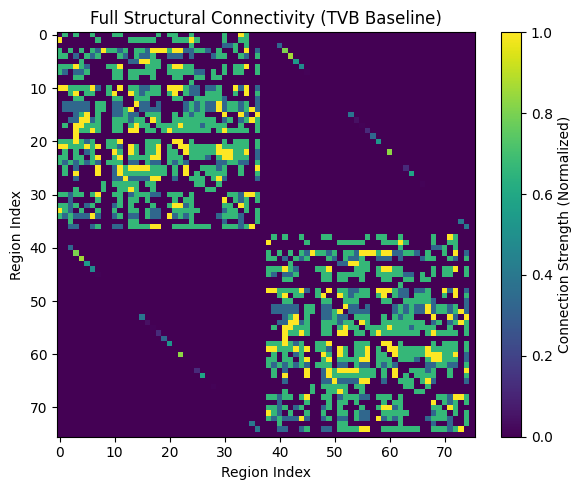

In [11]:
plt.figure(figsize=(6, 5))
plt.imshow(W_full, aspect="auto", cmap='viridis')
plt.title("Full Structural Connectivity (TVB Baseline)")
plt.xlabel("Region Index")
plt.ylabel("Region Index")
plt.colorbar(label="Connection Strength (Normalized)")
plt.tight_layout()
plt.show()

## 2.2 Clinical Network Selection (*The "Mini-Brain" Design*)

We selectively reduce the connectome to include only nodes relevant to the neurodegenerative pathologies under study.

### 2.2.1 Node Targeting (DMN & FT Networks)

In [12]:
# The following regions are typically the primary targets in Alzheimer's Disease (AD)
dmn_names = [
    "rCCP",
    "rPCI",
    "rPCIP",
    "rPCM",
]

# Mapping names to index
dmn_idx = [i for i, lab in enumerate(labels_full) if lab in dmn_names]
dmn_idx

[4, 13, 14, 15]

In [13]:
# These regions are the hallmarks of Frontotemporal Dementia (FTD)
ft_names = [
    "rPFCM",
    "rPFCDL",
    "rPFCDM",
    "rPFCORB",
    "rPHC",
    "rAMYG",
]

# Mapping names to index
ft_idx = [i for i, lab in enumerate(labels_full) if lab in ft_names]
ft_idx

[2, 18, 19, 20, 21, 24]

In [14]:
# Aggregate indices for the reduced "Mini-Brain" model
sel_idx = dmn_idx + ft_idx
sel_idx

[4, 13, 14, 15, 2, 18, 19, 20, 21, 24]

### 2.2.2 Extract Reduced Matrices

In [15]:
# We derive the Healthy Control (HC) baseline for the Mini-Brain
labels_mini = labels_full[sel_idx] # Names of selected regions
SC_mini = W_full[np.ix_(sel_idx, sel_idx)] # Subset of the weights
L_mini  = L_full[np.ix_(sel_idx, sel_idx)] # Subset of the lengths

print(f"Mini-Brain established with {len(labels_mini)} regions.")
print("Labels:", labels_mini)

Mini-Brain established with 10 regions.
Labels: ['rCCP' 'rPCI' 'rPCIP' 'rPCM' 'rAMYG' 'rPFCDL' 'rPFCDM' 'rPFCM' 'rPFCORB'
 'rPHC']


## 2.3 Metadata Management & Storage

To ensure traceability during the pathological degradation phase, we create a structured metadata table ("ID card") for each node.

In [16]:
!pip install pandas

In [17]:
import pandas as pd

In [18]:
# Save the mini-brain matrices to the project directory
np.save(os.path.join(paths["data"], "SC_mini_weights.npy"), SC_mini)
np.save(os.path.join(paths["data"], "SC_mini_lengths.npy"), L_mini)

### 2.3.1 Create Node Metadata Table

In [19]:
N_DMN = len(dmn_idx)
N_FT  = len(ft_idx)

In [20]:
# Create Node Lookup Table (Mapping anatomy to functional networks)
df_nodes = pd.DataFrame({
    "node": np.arange(len(labels_mini)),
    "label": labels_mini,
    "network": ["DMN"] * N_DMN + ["FT"] * N_FT
})

df_nodes.to_csv(
    os.path.join(paths["data"], "node_labels_mini.csv"),
    index=False
)

print("SC_mini, L_mini and node_labels_mini correctly saved.")

SC_mini, L_mini and node_labels_mini correctly saved.


### 2.3.2 Data Persistence & Integrity Verification

Before proceeding to the dynamical modeling, we reload the processed "Mini-Brain" data. This step ensures the integrity of the saved files and simulates a "clean start," verifying that all anatomical and network assignments are correctly preserved.

In [21]:
"""
We reload the processed mini-brain data to ensure persistence and integrity.
This step simulates a clean start for the dynamical modeling phase.
"""

SC_mini = np.load(os.path.join(paths["data"], "SC_mini_weights.npy"))
L_mini  = np.load(os.path.join(paths["data"], "SC_mini_lengths.npy"))  # We'll use it later for dalays
df_nodes = pd.read_csv(os.path.join(paths["data"], "node_labels_mini.csv"))

"""
In this block, we verify:
1. Node Ordering: Ensuring indices 0-9 match our expected anatomical sequence.
2. Label Accuracy: Checking that each ROI (Region of Interest) is correctly named.
3. Network Assignment: Confirming DMN vs FT categorization, which is the
   formal basis for our subsequent pathological manipulations.
"""

display(df_nodes)
print("SC_mini shape:", SC_mini.shape)


,node,label,network
0,0,rCCP,DMN
1,1,rPCI,DMN
2,2,rPCIP,DMN
3,3,rPCM,DMN
4,4,rAMYG,FT
5,5,rPFCDL,FT
6,6,rPFCDM,FT
7,7,rPFCM,FT
8,8,rPFCORB,FT
9,9,rPHC,FT


SC_mini shape: (10, 10)


### 2.3.3 Clinical Targeting Arrays

In [22]:
DMN_nodes = df_nodes.index[df_nodes["network"] == "DMN"].to_numpy()
FT_nodes = df_nodes.index[df_nodes["network"] == "FT"].to_numpy()

"""
We isolate the indices for FTD and AD targets into specialized arrays.
These will act as 'masks' to apply the pathology parameter (alpha)
selectively during the simulation.
"""

print(f"Targeting logic initialized:")
print(f" -> FT Network Nodes: {FT_nodes}")
print(f" -> DMN Network Nodes: {DMN_nodes}")

Targeting logic initialized:
 -> FT Network Nodes: [4 5 6 7 8 9]
 -> DMN Network Nodes: [0 1 2 3]


# **3. Brain Atlasing & Node Mapping**

The objective of this section is to anchor the "***Mini-Brain***" to an explicit anatomical reference.

By mapping nodes to a standard coordinate system, we enable the interpretation of dynamic results in terms of real human neuroanatomy. Each node is assigned:

- **Spatial Coordinates**: XYZ center of gravity (MNI space) from the TVB connectome.

- **Functional Label**: Membership in the Default Mode Network (DMN) or Frontotemporal (FT) network.

- **Volumetric Context**: Integration with the Harvard-Oxford Atlas for subsequent 3D brain visualization

## 3.1 Coordinate Extraction & Integration

We map the ROI labels from our reduced model back to the original TVB spatial metadata.

### 3.1.1 Extracting Spatial Centers from TVB

In [23]:
# We retrieve the anatomical centers (in MNI mm) for the full 76-node connectome.
labels_full  = np.array(conn.region_labels)
centres_full = np.array(conn.centres)

df_atlas = pd.DataFrame({
    "roi": np.arange(len(labels_full)),
    "label": labels_full,
    "x": centres_full[:, 0],
    "y": centres_full[:, 1],
    "z": centres_full[:, 2],
})

display(df_atlas.head())
print("df_atlas shape:", df_atlas.shape)

atlas_out = os.path.join(paths["results"], "atlas")
os.makedirs(atlas_out, exist_ok=True)
df_atlas.to_csv(os.path.join(atlas_out, "tvb_roi_centres.csv"), index=False)
print("Saved:", os.path.join(atlas_out, "tvb_roi_centres.csv"))

,roi,label,x,y,z
0,0,rA1,-9.885591,-47.084818,-3.139360
1,1,rA2,-2.605247,-55.324507,-7.065423
2,2,rAMYG,6.489431,-11.670519,-30.851544
3,3,rCCA,48.734149,-2.004701,8.019123
4,4,rCCP,-12.171400,-6.494719,25.361539


df_atlas shape: (76, 5)
Saved: /content/drive/MyDrive/BMproject/results/atlas/tvb_roi_centres.csv


At this point, each ROI in the connectome is associated with a spatial location.

### 3.1.2 Mappung Mini-Brain Nodes to MNI Space

In [24]:
# We merge our clinical node table with the spatial coordinates.
df_nodes = pd.read_csv(os.path.join(paths["data"], "node_labels_mini.csv"))
print("df_nodes shape:", df_nodes.shape)
display(df_nodes)

df_mini_atlas = df_nodes.merge(
    df_atlas[["roi", "label", "x", "y", "z"]],
    on="label",
    how="left"
)

print("df_mini_atlas shape:", df_mini_atlas.shape)
display(df_mini_atlas)

# Integrity Check: Ensure no nodes are 'lost' in space
missing_xyz = df_mini_atlas[["x", "y", "z"]].isna().any(axis=1)
if missing_xyz.any():
    print("ATTENTION: some mini-brain's labels don't have coordinates (failed merging).")
    display(df_mini_atlas[missing_xyz])
else:
    print("OK: coordinates present for all nodes of the mini-brain.")

df_mini_atlas.to_csv(os.path.join(atlas_out, "mini_nodes_with_tvb_centres.csv"), index=False)
print("Saved:", os.path.join(atlas_out, "mini_nodes_with_tvb_centres.csv"))

df_nodes shape: (10, 3)


,node,label,network
0,0,rCCP,DMN
1,1,rPCI,DMN
2,2,rPCIP,DMN
3,3,rPCM,DMN
4,4,rAMYG,FT
5,5,rPFCDL,FT
6,6,rPFCDM,FT
7,7,rPFCM,FT
8,8,rPFCORB,FT
9,9,rPHC,FT


df_mini_atlas shape: (10, 7)


,node,label,network,roi,x,y,z
0,0,rCCP,DMN,4,-12.171400,-6.494719,25.361539
1,1,rPCI,DMN,13,-22.152851,-56.734891,16.852029
2,2,rPCIP,DMN,14,-51.151034,-35.899675,25.679908
3,3,rPCM,DMN,15,-43.927847,-8.226723,27.584594
4,4,rAMYG,FT,2,6.489431,-11.670519,-30.851544
5,5,rPFCDL,FT,18,59.995574,-14.366518,26.025739
6,6,rPFCDM,FT,19,59.612735,-2.407101,-0.844581
7,7,rPFCM,FT,20,59.286775,-2.547348,-21.924281
8,8,rPFCORB,FT,21,47.987255,-16.887697,-39.699154
9,9,rPHC,FT,24,-14.494840,-20.328269,-27.617052


OK: coordinates present for all nodes of the mini-brain.
Saved: /content/drive/MyDrive/BMproject/results/atlas/mini_nodes_with_tvb_centres.csv


## 3.2 Spatial Quality Control (QC)

To verify the anatomical plausibility of our Mini-Brain, we visualize the node centers in 3D and check their bounding box against standard MNI dimensions.

### 3.2.1 3D Spatial Distribution (DMN vs FT)

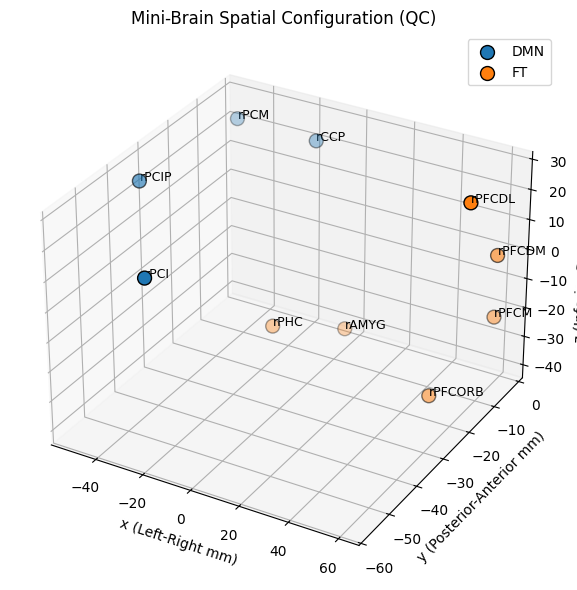

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Color-coding nodes by their functional network
colors = {"DMN": "tab:blue", "FT": "tab:orange"}

for net in sorted(df_mini_atlas["network"].unique()):
    sub = df_mini_atlas[df_mini_atlas["network"] == net]
    ax.scatter(sub["x"], sub["y"], sub["z"], s=100, label=net, c=colors[net], edgecolors='k')

# Labeling individual ROIs for clarity
for _, r in df_mini_atlas.iterrows():
    ax.text(r["x"], r["y"], r["z"], r["label"], fontsize=9)

ax.set_title("Mini-Brain Spatial Configuration (QC)")
ax.set_xlabel("x (Left-Right mm)")
ax.set_ylabel("y (Posterior-Anterior mm)")
ax.set_zlabel("z (Inferior-Superior mm)")
ax.legend()
plt.tight_layout()
plt.show()

### 3.2.2 Numerical Bounding Box Check

In [26]:
# Standard MNI coordinates roughly range from -90 to +90.
mins = df_mini_atlas[["x","y","z"]].min().to_dict()
maxs = df_mini_atlas[["x","y","z"]].max().to_dict()

print("Mini nodes bbox (mm):")
print("  min:", mins)
print("  max:", maxs)

Mini nodes bbox (mm):
  min: {'x': -51.151034, 'y': -56.734891, 'z': -39.699154}
  max: {'x': 59.995574, 'y': -2.407101, 'z': 27.584594}


# **4. Structural Part**

In this section, we implement the mathematical framework for **neurodegeneration**.

We introduce a control parameter, $\alpha \in [0, 1]$, representing disease severity:

- $\alpha = 0$: Healthy Control (HC) state.

- $\alpha \to 1$: Progressive structural decoupling and network fragmentation.

**Note**: The analysis here is static: for each value of alpha we generate a connectivity matrix. This allows us to study how network connections change progressively as disease severity increases.

## 4.1 Degradation Functions

We model two distinct pathological phenotypes:

- **Alzheimer’s Disease** (AD): Characterized by diffuse, global synaptic loss and axonal tension reduction, modeled as a uniform scaling of all weights.

- **Frontotemporal Dementia** (FTD): Characterized by targeted degradation of frontotemporal circuits, modeled using an anatomical mask.

### 4.1.1 Connectivity Modulation Functions

In [27]:
def make_SC_HC(SC):
    """Healthy control (HC): intact structural connectivity."""
    return SC.copy()

def make_SC_AD(SC, alpha):
    """
    Alzheimer’s disease (AD): global degeneration.
    Simple implementation based on uniform scaling of all connection weights.
    """
    alpha = float(alpha)
    alpha = np.clip(alpha, 0.0, 1.0)

    """
    alpha = 0   → healthy brain
    alpha → 1   → severely degraded network
    All connections are weakened uniformly.
    """

    return (1.0 - alpha) * SC

def make_SC_FTD(SC, alpha, ft_nodes):
    """
    Frontotemporal dementia (FTD): selective degeneration.
    Affects connections involving frontotemporal (FT) nodes
    (both incoming and outgoing connections).
    """
    alpha = float(alpha)
    alpha = np.clip(alpha, 0.0, 1.0)

    """
    An anatomical mask is constructed:
    M = 1 → vulnerable connection
    M = 0 → preserved connection

    The mask targets:
    - all connections to and from FT nodes
    - excludes self-connections

    This directly encodes the assumption that
    if a region is affected by pathology, its connections are also compromised.
    """

    M = np.zeros_like(SC)
    M[ft_nodes, :] = 1.0
    M[:, ft_nodes] = 1.0
    np.fill_diagonal(M, 0.0)

    return SC * (1.0 - alpha * M)

###4.1.2 Progressive Severity Grid

We here define a  disease severity scale, which allows us to:
- Study disease progression;
- Go beyond a simple healthy vs diseased comparison
- Observe gradual transitions in network structure.

In [28]:
alpha_grid = np.arange(0.0, 1.0, 0.1)

"""
We now build collections of structural connectomes.
Not a single AD or FTD brain, but:
- a family of AD networks
- a family of FTD networks
each corresponding to a different disease severity level.
"""

SC_AD  = {}
SC_FTD = {}

for i, alpha in enumerate(alpha_grid):
    SC_AD[i]  = make_SC_AD(SC_mini, alpha)
    SC_FTD[i] = make_SC_FTD(SC_mini, alpha, FT_nodes)

print(f"Generated {len(alpha_grid)} severity levels for AD and FTD models.")

Generated 10 severity levels for AD and FTD models.


## 4.2 Visualization & Comparative Analysis

Visual verification ensures that our mathematical masks correctly target the intended anatomical regions. By fixing the color scale ($v_{min}=0, v_{max}=1$), we can objectively compare the loss of connectivity across conditions.

### 4.2.1 Visualaization Utilities

In [29]:
def plot_three(SC1, SC2, SC3, titles, figsize=(12,4)):
    """
    Plots three Structural Connectivity matrices side-by-side for comparison.
    A fixed vmin/vmax is used to ensure the color intensity represents
    absolute weight values consistently across plots.
    """
    plt.figure(figsize=figsize)
    for i, (SC, title) in enumerate(zip([SC1, SC2, SC3], titles), start=1):
        plt.subplot(1,3,i)
        plt.imshow(SC, aspect="auto")
        plt.title(title)
        plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()


In [30]:
# Baseline Healthy Control
SC_HC = make_SC_HC(SC_mini)

### 4.2.2 Static Demonstration (Intermediate Severity)

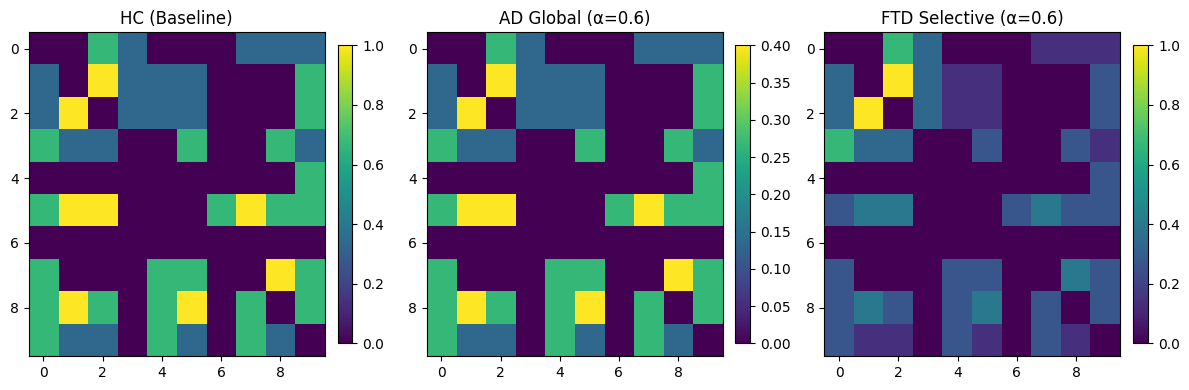

In [31]:
# We visualize an intermediate stage (alpha = 0.6) to inspect the divergence between global and selective degradation.
i_demo = 6
plot_three(
    SC_HC,
    SC_AD[i_demo],
    SC_FTD[i_demo],
    titles=[
        "HC (Baseline)",
        f"AD Global (α={alpha_grid[i_demo]:.1f})",
        f"FTD Selective (α={alpha_grid[i_demo]:.1f})"
    ]
)

**Qualitative interpretation**:
- HC  → Dense and balanced structural connectivity.
- AD  → Global 'fading' of the matrix; network topology is preserved
        but connections are uniformly weakened.
- FTD → Localized connectivity voids; specific blocks related to
        the FT network are degraded while others remain intact.

### 4.2.3 Interactive exploration

In [32]:
import ipywidgets as widgets
from IPython.display import display

In [33]:
def update(alpha):
    """Callback function for the interactive severity slider."""
    SC_ad  = make_SC_AD(SC_mini, alpha)
    SC_ftd = make_SC_FTD(SC_mini, alpha, FT_nodes)

    plot_three(
        SC_HC,
        SC_ad,
        SC_ftd,
        titles=[
            "HC (baseline)",
            f"AD – global (alpha={alpha:.2f})",
            f"FTD – selective (alpha={alpha:.2f})"
        ]
    )

In [34]:
alpha_slider = widgets.FloatSlider(
    value=0.3,
    min=0.0,
    max=0.9,
    step=0.05,
    description="alpha",
    continuous_update=False
)
widgets.interact(update, alpha=alpha_slider);

interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='alpha', max=0.9, step=0.05)…

# **`Model Simulation`**

# **5. Dynamical Part**

While structural analysis provides a snapshot of the brain's "wiring", the dynamical model simulates the "firing".

We implement a **Wilson-Cowan Neural Mass Model** to investigate how microscopic synaptic alterations propagate into macroscopic network dysfunction.


**Biophysical Mechanisms of the Model**:

1. **Excitatory/Inhibitory** (E/I) Balance: We model recurrent excitation ($w_{EE}$) and feedback inhibition ($w_{EI}$), reflecting the synaptic dysfunction that precedes atrophy.

2. **Network-Specific Vulnerability**: Pathological rules target the DMN in Alzheimer’s Disease and the FT network in Frontotemporal Dementia.

3. **The "Working Point"**: By simulating activity, we move from observing "what changes" to understanding "how it changes" dynamically.

## 5.1 Parameter Configuration

We define the baseline physiological state (Healthy Control) and the numerical integration settings.

### 5.1.1 Baseline (Healthy) Wilson–Cowan Parameters

In [35]:
WC_params = {
    "tau_e": 1.0, "tau_i": 2.0,  # Time constants
    "w_EE": 12.0, "w_EI": 15.0, "w_IE": 13.0, "w_II": 11.0,  # Synaptic weights
    "theta_e": 4.0, "theta_i": 3.7,  # Firing thresholds
    "k_e": 1.2, "k_i": 1.0,  # Sigmoid gains
    "P": 0.5  # External background drive
}

### 5.1.2 Simulation Parameters

In [36]:
T_sim = 20.0  # Total duration (seconds)
dt = 0.001  # Integration step (1ms)
burnin = 0.3  # Percentage of signal to discard (initial transient)
cut = int(burnin * (T_sim / dt))
noise = 0.01  # Stochastic fluctuation amplitude

## 5.2 Pathological Parameter Modulation

The following functions translate the $\alpha$ severity parameter into specific synaptic alterations, inspired by ***Monteverdi et al. (2023)***.

### 5.2.1 Pathological Parameter Modulation

In [37]:
def get_pathological_params(group, alpha, n_nodes, df_nodes):
    """
    Modulates local biophysical parameters based on clinical phenotype.
    AD: DMN hyperexcitability.
    FTD: Selective frontotemporal disinhibition.
    """
    params_list = []

    for i in range(n_nodes):
        p = WC_params.copy()
        network = df_nodes.iloc[i]['network']

        if group == "AD":
             # AD: DMN hyperexcitability and limbic/frontotemporal disinhibition
            if network == "DMN":
                p["w_EE"] *= (1.0 + 0.4 * alpha)
            if network == "FT":
                p["w_EI"] *= (1.0 - 0.3 * alpha)

        elif group == "FTD":
            # FTD: strong disinhibition and hyperexcitability in FT network
            if network == "FT":
                p["w_EI"] *= (1.0 - 0.5 * alpha)
                p["w_EE"] *= (1.0 + 0.3 * alpha)
            # Relative over-inhibition of DMN in FTD
            if network == "DMN":
                p["w_EI"] *= (1.0 + 0.3 * alpha)

        params_list.append(p)
    return params_list

### 5.2.2 Core Integration Engine

In [38]:
# Sigmoidal activation function
def sigmoid(x, theta, k):
    return 1 / (1 + np.exp(-k * (x - theta)))

def wc_step(E, I, p, input_net, dt, noise, rng):
    """
    Single integration step of Wilson–Cowan dynamics
    for one node with node-specific parameters.
    """
    dE = (-E + sigmoid(p["w_EE"]*E - p["w_IE"]*I + p["P"] + input_net, p["theta_e"], p["k_e"])) / p["tau_e"]
    dI = (-I + sigmoid(p["w_EI"]*E - p["w_II"]*I, p["theta_i"], p["k_i"])) / p["tau_i"]

    E_next = E + dE * dt + noise * np.sqrt(dt) * rng.standard_normal()
    I_next = I + dI * dt + noise * np.sqrt(dt) * rng.standard_normal()

    return np.clip(E_next, 0, 1), np.clip(I_next, 0, 1)

def simulate_wc_network(SC, G, params_list, T, dt, noise, seed):
    """
    Simulate whole-brain Wilson–Cowan dynamics with
    structural coupling and node-specific parameters.
    """
    rng = np.random.default_rng(seed)
    N = SC.shape[0]
    steps = int(T / dt)
    E = 0.1 * np.ones(N)
    I = 0.1 * np.ones(N)
    E_traj = np.zeros((steps, N))

    for t in range(steps):
        E_old = E.copy()
        for i in range(N):
            # GLobal coupling weighted by SC
            input_net = G * np.sum(SC[i, :] * E_old)

            # Using list of parameters depending on alpha
            E[i], I[i] = wc_step(E[i], I[i], params_list[i], input_net, dt, noise, rng)
        E_traj[t] = E
    return E_traj

## 5.3 Comparative Results (HC vs. AD vs. FTD)

We simulate all conditions at a representative severity ($\alpha = 0.6$) to compare their dynamic "fingerprints."

### 5.3.1 Coordinated Simulation Execution

In [39]:
def run_condition(group, alpha, SC_base, df_nodes, seed=42):
    """
    Coordinates the three layers of pathology:
    A) Structural degradation
    B) Global coupling modulation
    C) Local biophysical parameter changes
    """
    n_nodes = SC_base.shape[0]

    # Structural connectivity and global coupling
    if group == "AD":
        SC = SC_base * (1 - 0.5 * alpha)
        G = 0.5 + (0.3 * alpha)
    elif group == "FTD":
        mask = np.ones_like(SC_base)
        ft_indices = df_nodes[df_nodes['network'] == 'FT'].index
        for idx in ft_indices:
            mask[idx, :] = (1 - alpha)
            mask[:, idx] = (1 - alpha)
        SC = SC_base * mask
        G = 0.5 - (0.1 * alpha)
    else:
        SC = SC_base
        G = 0.5

    # Local biophysical parameters
    p_list = get_pathological_params(group, alpha, n_nodes, df_nodes)

    # Simulation
    results = simulate_wc_network(SC, G, p_list, T_sim, dt, noise, seed)
    return results[cut:]

In [40]:
# Run simulations
chosen_alpha = 0.6
seed_val = 42
E_AD  = run_condition("AD", chosen_alpha, SC_mini, df_nodes, seed_val)
E_FTD = run_condition("FTD", chosen_alpha, SC_mini, df_nodes, seed_val)
E_HC  = run_condition("HC", 0.0, SC_mini, df_nodes, seed_val)

### 5.3.2 Dynamical Signature Visualization

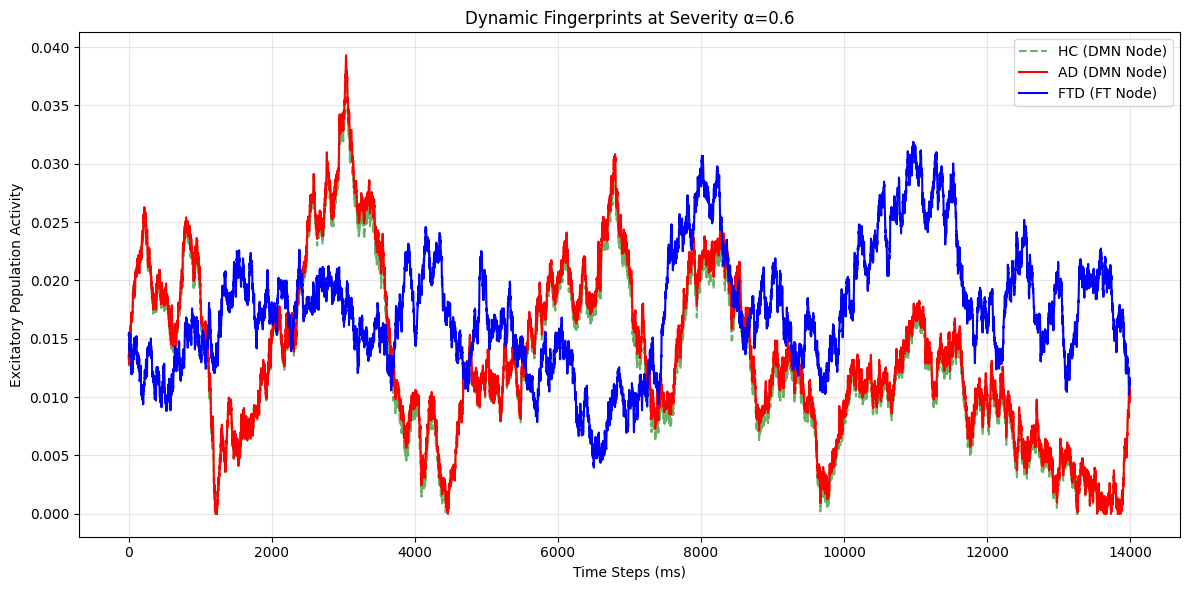

In [41]:
node_dmn, node_ft = DMN_nodes[0], FT_nodes[0]
plt.figure(figsize=(12, 6))

# Plotting logic with distinct styles for clarity
plt.plot(E_HC[:, node_dmn],  label="HC (DMN Node)",  ls='--', color='green', alpha=0.6)
plt.plot(E_AD[:, node_dmn],  label="AD (DMN Node)",  color='red', lw=1.5)
plt.plot(E_FTD[:, node_ft],  label="FTD (FT Node)", color='blue', lw=1.5)

plt.xlabel("Time Steps (ms)")
plt.ylabel("Excitatory Population Activity")
plt.title(f"Dynamic Fingerprints at Severity α={chosen_alpha}")
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Summary of Findings**

The comparative plots reveal distinct dynamic signatures:

- **Healthy Control** (HC): Exhibits stable, low-amplitude baseline activity.

- **Alzheimer's Disease** (AD): Demonstrates hypersynchronization and increased amplitude, reflecting global structural weakening countered by pathological global coupling and local DMN hyperexcitability.

- **Frontotemporal Dementia** (FTD): Shows selective alterations in FT nodes, consistent with localized disconnection and specific circuit instability.

# **6. Simulated Brain Network Dynamics**
Simulate the **evolution** of **excitatory** and **inhibitory** activity across  brain regions, comparing healthy controls and disease conditions (AD, FTD) using the Wilson–Cowan model. This allows us to study **how** **structural** connectivity and compensatory mechanisms **shape** **functional** dynamics.

## 6.1 Simulation Hyperparameters & Global Coupling Logic
Define numerical settings, disease severity (alpha), and global coupling adjustments per clinical condition.

In [42]:
dt = 1e-3
T_sim = 10.0
burnin = 0.3
noise = 0.01

# We define a range of disease severity from 0.0 (Healthy) to 0.9 (Severe).
alpha_grid = np.arange(0.0, 1.0, 0.1)
# We simulate 3 different 'virtual subjects' (seeds) for each condition.
seeds = range(3)
N = SC_HC.shape[0]  # Number of ROIs in our 'mini-brain'
# We convert the total simulation time (T_sim) into discrete numerical steps
steps = int(T_sim / dt)
cut = int(burnin * steps)  # Defines the number of initial steps to discard.

In [43]:
G0 = 0.5  # Baseline healthy coupling
k_AD = 0.4 # Slope for AD compensatory hypersynchrony

def G_AD(alpha):
    """In Alzheimer's, global coupling increases with severity to simulate
    network 'rigidity' and hypersynchronization despite structural loss."""
    return G0 + k_AD * alpha

def G_FTD(alpha):
    """In FTD, we assume a local failure without global compensatory changes."""
    return G0

print("N:", N, "steps:", steps, "cut:", cut)
print("Example G_AD(alpha=0.9):", G_AD(0.9))

N: 10 steps: 10000 cut: 3000
Example G_AD(alpha=0.9): 0.8600000000000001


## 6.2 Time-Series Generation & Storage
Generate and save synthetic E/I activity for each group, severity, and random seed.

In [44]:
import os
out_ts = os.path.join(paths["results"], "timeseries_Gvar")
os.makedirs(out_ts, exist_ok=True)

def save_ts(arr, fname):
    np.save(os.path.join(out_ts, fname), arr)

In [45]:
"""
HEALTHY CONTROL (HC) GROUP
  We generate the baseline activity using the original SC_mini with no degradation (alpha=0).
  The global coupling (G) is kept at the physiological baseline (G0).
"""
for seed in seeds:
    E = run_condition("HC", 0.0, SC_mini, df_nodes, seed)
    save_ts(E, f"E_HC_G{G0:.2f}_seed{seed}.npy")

"""
ALZHEIMER'S DISEASE (AD) GROUP
  We iterate through the alpha_grid to simulate disease progression.
  For each level, we apply:
    - Global Structural Degradation (via run_condition)
    - Increasing Global Coupling (G_AD) to simulate compensatory hypersynchrony.
"""
for i, alpha in enumerate(alpha_grid):
    for seed in seeds:
        E_ad = run_condition("AD", alpha, SC_mini, df_nodes, seed)
        # Update fname to reflect the G calculated by G_AD(alpha)
        save_ts(E_ad, f"E_AD_i{i}_alpha{alpha:.1f}_G{G_AD(alpha):.2f}_seed{seed}.npy")

"""
FRONTOTEMPORAL DEMENTIA (FTD) GROUP
  We simulate selective network failure.
  Unlike AD, we keep the Global Coupling (G) at baseline (G_FTD),
  as FTD is characterized by localized disconnectivity rather than global rigidity.
"""
for i, alpha in enumerate(alpha_grid):
    for seed in seeds:
        E_ftd = run_condition("FTD", alpha, SC_mini, df_nodes, seed)
        # Update fname to reflect the G calculated by G_FTD(alpha)
        save_ts(E_ftd, f"E_FTD_i{i}_alpha{alpha:.1f}_G{G_FTD(alpha):.2f}_seed{seed}.npy")

print("Saved time series in:", out_ts)

Saved time series in: /content/drive/MyDrive/BMproject/results/timeseries_Gvar


## 6.3 FC Calculation & Modular Metrics

Compute functional connectivity matrices and modular (DMN/FT) metrics from the simulated time series.

In [46]:
# STATISTICAL NORMALIZATION (Z-SCORE): We normalize signals to mean 0 and std 1 to compute pure Pearson correlations.
def zscore(X, axis=0, eps=1e-12):
    m = X.mean(axis=axis, keepdims=True)
    s = X.std(axis=axis, keepdims=True) + eps
    return (X - m) / s

# FUNCTIONAL CONNECTIVITY (FC) MATRIX: FC represents the 'functional co-activation' between brain regions.
def fc_corr(E):
    Ez = zscore(E, axis=0)
    FC = (Ez.T @ Ez) / (Ez.shape[0] - 1)
    np.fill_diagonal(FC, 0.0)
    return FC

# NETWORK-SPECIFIC (MODULAR) ANALYSIS: We split the analysis into DMN and FT modules to observe selective degradation.
def fc_mean_abs(FC):
    iu = np.triu_indices_from(FC, k=1)
    return float(np.mean(np.abs(FC[iu])))


### 6.3.1 Modular Connectivity Analysis

Partition FC into within- and between-network connectivity blocks to track selective degradation.


In [47]:
"""
NODE GROUPING BY NETWORK
We reload the metadata to identify which nodes belong to the DMN and which to the FT network.
These indices are used to slice the FC matrix into specific 'blocks'.
"""
df_nodes = pd.read_csv(
    os.path.join(paths["data"], "node_labels_mini.csv")
)


DMN_nodes = df_nodes.index[df_nodes["network"] == "DMN"].to_numpy()
FT_nodes  = df_nodes.index[df_nodes["network"] == "FT"].to_numpy()

def mean_block(FC, idxA, idxB):
    """
    Computes the average connectivity within or between brain modules.
    - If idxA == idxB: We calculate internal connectivity (Within-Network),
      excluding the diagonal (self-correlations).
    - If idxA != idxB: We calculate the average interaction between two
      different networks (Between-Network).
    """
    block = FC[np.ix_(idxA, idxB)]
    if np.array_equal(idxA, idxB):
        mask = ~np.eye(len(idxA), dtype=bool)
        vals = block[mask]
    else:
        # For between-network, we take all values in the cross-block
        vals = block.ravel()
    return float(np.mean(vals))

# METRIC AGGREGATION
def module_metrics(FC):
    """
    Consolidates the global and modular metrics into a single dictionary.
    This provides a 'functional snapshot' of the brain's state.
    """
    return dict(
        FC_mean_abs = fc_mean_abs(FC),
        FC_DMN = mean_block(FC, DMN_nodes, DMN_nodes),
        FC_FT  = mean_block(FC, FT_nodes, FT_nodes),
        FC_between = mean_block(FC, DMN_nodes, FT_nodes)
    )

## 6.4 Data Aggregation & Final Reporting
Aggregate all metrics into a summary table and generate plots showing global and module-specific FC versus disease severity.

In [48]:
import re

rows = []

for fname in sorted(os.listdir(out_ts)):
    if not fname.endswith(".npy"):
        continue

    E = np.load(os.path.join(out_ts, fname))
    FC = fc_corr(E)
    m = module_metrics(FC)

    # group
    if fname.startswith("E_HC"):
        group = "HC"
        alpha = 0.0
    else:
        group = "AD" if "_AD_" in fname else "FTD"
        alpha = float(re.search(r"alpha([0-9.]+)", fname).group(1))

    # seed
    seed = int(re.search(r"seed(\d+)", fname).group(1))

    # G from filename
    G_val = float(re.search(r"_G([0-9.]+)_", fname).group(1))

    rows.append({"group": group, "alpha": alpha, "G": G_val, "seed": seed, **m})

df_metrics = pd.DataFrame(rows)
df_metrics.to_csv(os.path.join(paths["results"], "metrics_fc_Gvar.csv"), index=False)

df_metrics.head()



,group,alpha,G,seed,FC_mean_abs,FC_DMN,FC_FT,FC_between
0,AD,0.0,0.50,0,0.239347,-0.186898,-0.072153,0.019164
1,AD,0.0,0.50,1,0.254888,-0.083810,-0.023880,0.036681
2,AD,0.0,0.50,2,0.204479,-0.007463,-0.031055,0.020307
3,AD,0.1,0.54,0,0.239706,-0.186526,-0.071978,0.019592
4,AD,0.1,0.54,1,0.255248,-0.084044,-0.024230,0.036477


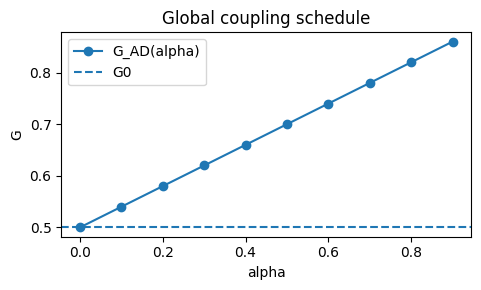

'\nShow how the G parameter (how much brain regions influence each other):\n- remains fixed in the healthy brain (HC)\n- progressively increases with severity (alpha) in Alzheimer\'s disease (AD).\nThe dotted line is the healthy reference value.\nIn AD, as the disease worsens, the brain becomes more "rigid":\neven if structural connections are lost, global coupling increases.\n'

In [49]:
plt.figure(figsize=(5,3))
plt.plot(alpha_grid, [G_AD(a) for a in alpha_grid], marker="o", label="G_AD(alpha)")
plt.axhline(G0, linestyle="--", label="G0")
plt.xlabel("alpha")
plt.ylabel("G")
plt.title("Global coupling schedule")
plt.legend()
plt.tight_layout()
plt.show()

"""
Show how the G parameter (how much brain regions influence each other):
- remains fixed in the healthy brain (HC)
- progressively increases with severity (alpha) in Alzheimer's disease (AD).
The dotted line is the healthy reference value.
In AD, as the disease worsens, the brain becomes more "rigid":
even if structural connections are lost, global coupling increases.
"""

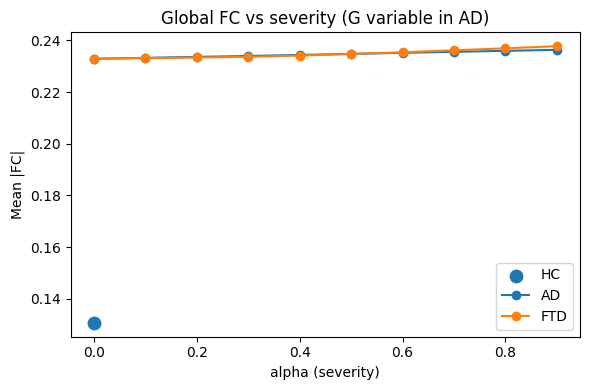

In [50]:
summary = (
    df_metrics
    .groupby(["group", "alpha"])
    .agg(mean=("FC_mean_abs", "mean"), std=("FC_mean_abs", "std"))
    .reset_index()
)

plt.figure(figsize=(6,4))

for grp in ["HC", "AD", "FTD"]:
    sub = summary[summary["group"] == grp]

    if grp == "HC":
        plt.scatter(sub["alpha"], sub["mean"], s=80, label="HC")
    else:
        plt.plot(sub["alpha"], sub["mean"], marker="o", label=grp)

plt.xlabel("alpha (severity)")
plt.ylabel("Mean |FC|")
plt.title("Global FC vs severity (G variable in AD)")
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
import ipywidgets as widgets
from IPython.display import display

groups = ["HC", "AD", "FTD"]

def plot_fc(groups_to_show):
    plt.figure(figsize=(6,4))

    for grp in groups_to_show:
        sub = summary[summary["group"] == grp]
        if grp == "HC":
            plt.scatter(sub["alpha"], sub["mean"], s=80, label="HC")
        else:
            plt.plot(sub["alpha"], sub["mean"], marker="o", label=grp)

    plt.xlabel("alpha (severity)")
    plt.ylabel("Mean |FC|")
    plt.title("Global FC vs severity (G variable in AD)")
    plt.legend()
    plt.tight_layout()
    plt.show()

widgets.interact(
    plot_fc,
    groups_to_show=widgets.SelectMultiple(
        options=groups,
        value=groups,
        description="Groups",
        disabled=False
    )
);


interactive(children=(SelectMultiple(description='Groups', index=(0, 1, 2), options=('HC', 'AD', 'FTD'), value…

In [52]:
import plotly.express as px

fig = px.line(
    summary,
    x="alpha",
    y="mean",
    color="group",
    markers=True,
    title="Global FC vs severity (G variable in AD)",
    labels={"mean": "Mean |FC|", "alpha": "alpha (severity)"}
)

fig.show()


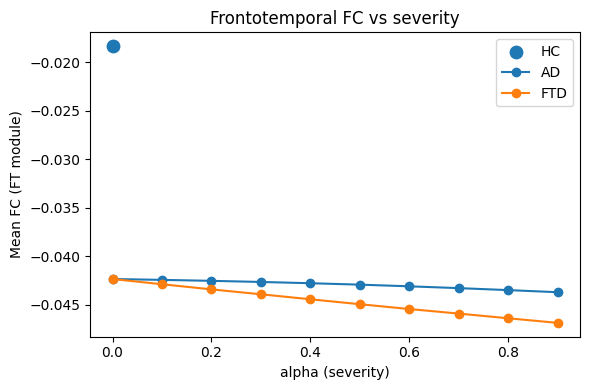

In [53]:
summary_FT = (
    df_metrics
    .groupby(["group", "alpha"])
    .agg(mean=("FC_FT", "mean"), std=("FC_FT", "std"))
    .reset_index()
)

plt.figure(figsize=(6,4))

for grp in ["HC", "AD", "FTD"]:
    sub = summary_FT[summary_FT["group"] == grp]

    if grp == "HC":
        plt.scatter(sub["alpha"], sub["mean"], s=80, label="HC")
    else:
        plt.plot(sub["alpha"], sub["mean"], marker="o", label=grp)

plt.xlabel("alpha (severity)")
plt.ylabel("Mean FC (FT module)")
plt.title("Frontotemporal FC vs severity")
plt.legend()
plt.tight_layout()
plt.show()


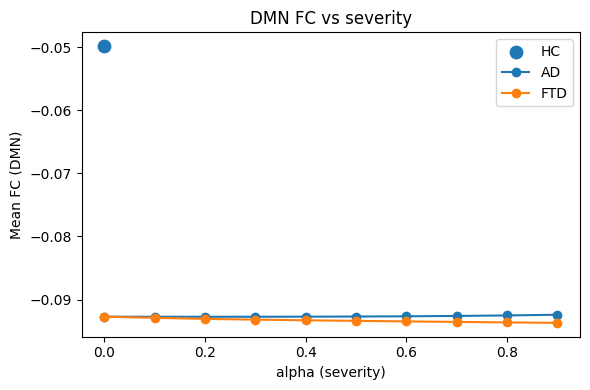

In [54]:
summary_DMN = (
    df_metrics
    .groupby(["group", "alpha"])
    .agg(mean=("FC_DMN", "mean"), std=("FC_DMN", "std"))
    .reset_index()
)

plt.figure(figsize=(6,4))

for grp in ["HC", "AD", "FTD"]:
    sub = summary_DMN[summary_DMN["group"] == grp]
    if grp == "HC":
        plt.scatter(sub["alpha"], sub["mean"], s=80, label="HC")
    else:
        plt.plot(sub["alpha"], sub["mean"], marker="o", label=grp)

plt.xlabel("alpha (severity)")
plt.ylabel("Mean FC (DMN)")
plt.title("DMN FC vs severity")
plt.legend()
plt.tight_layout()
plt.show()


# **7. Phase Plane Analysis**
Quantifies how network-level pathology translates to local circuit dysfunction, revealing disease-specific instability mechanisms and predicting which circuits are most vulnerable to further degeneration.

## 7.1 Working Point Shift
We take a large network, reduce it to a single effective input, feed this input into a single-node model, and observe how the equilibrium (working point) shifts.

### 7.1.1 Network Simulation Cells
Simulate the full network for HC, AD, and FTD.

In [55]:
WC_params_base = {
    "tau_e": 1.0, "tau_i": 2.0,
    "w_EE": 12.0, "w_EI": 15.0, "w_IE": 13.0, "w_II": 11.0,
    "theta_e": 4.0, "theta_i": 3.7,
    "k_e": 1.2, "k_i": 1.0,
    "P": 0.5
}

In [56]:
def get_pathological_params(group, alpha, n_nodes, df_nodes):
    params_list = []
    for i in range(n_nodes):
        p = WC_params_base.copy()
        network = df_nodes.iloc[i]['network']

        if group == "AD":
            if network == "DMN":
                p["w_EE"] *= (1.0 + 0.4 * alpha)
            if network == "FT":
                p["w_EI"] *= (1.0 - 0.3 * alpha)
        elif group == "FTD":
            if network == "FT":
                p["w_EI"] *= (1.0 - 0.5 * alpha)
                p["w_EE"] *= (1.0 + 0.3 * alpha)
            if network == "DMN":
                p["w_EI"] *= (1.0 + 0.3 * alpha)
        params_list.append(p)
    return params_list

def sigmoid(x, theta, k):
    return 1 / (1 + np.exp(-k * (x - theta)))

def wc_step(E, I, p, input_net, dt, noise, rng):
    dE = (-E + sigmoid(p["w_EE"]*E - p["w_IE"]*I + p["P"] + input_net, p["theta_e"], p["k_e"])) / p["tau_e"]
    dI = (-I + sigmoid(p["w_EI"]*E - p["w_II"]*I, p["theta_i"], p["k_i"])) / p["tau_i"]
    E_next = E + dE * dt + noise * np.sqrt(dt) * rng.standard_normal()
    I_next = I + dI * dt + noise * np.sqrt(dt) * rng.standard_normal()
    return np.clip(E_next, 0, 1), np.clip(I_next, 0, 1)

def simulate_wc_network(SC, G, params_list, T, dt, noise, seed):
    rng = np.random.default_rng(seed)
    N = SC.shape[0]
    steps = int(T / dt)
    E = 0.1 * np.ones(N)
    I = 0.1 * np.ones(N)
    E_traj = np.zeros((steps, N))
    for t in range(steps):
        E_old = E.copy()
        for i in range(N):
            input_net = G * np.sum(SC[i, :] * E_old)
            E[i], I[i] = wc_step(E[i], I[i], params_list[i], input_net, dt, noise, rng)
        E_traj[t] = E
    return E_traj


### 7.1.2 Network Reduction to a Single Input
Compress the full network into a single effective input per node

In [57]:
def run_condition(group, alpha, SC_base, df_nodes, seed=42):
    n_nodes = SC_base.shape[0]
    if group == "AD":
        SC = SC_base * (1 - 0.5 * alpha)
        G = 0.5 + (0.3 * alpha)
    elif group == "FTD":
        mask = np.ones_like(SC_base)
        ft_indices = df_nodes[df_nodes['network'] == 'FT'].index
        for idx in ft_indices:
            mask[idx, :] = (1 - alpha)
            mask[:, idx] = (1 - alpha)
        SC = SC_base * mask
        G = 0.5 - (0.1 * alpha)
    else:
        SC = SC_base
        G = 0.5
    p_list = get_pathological_params(group, alpha, n_nodes, df_nodes)
    results = simulate_wc_network(SC, G, p_list, T_sim, dt, noise, seed)
    return results[cut:]

In [58]:
i_demo = 8
alpha_demo = float(alpha_grid[i_demo])

seeds_pp = list(range(5))

In [59]:
i_node_DMN = int(DMN_nodes[0])
i_node_FT  = int(FT_nodes[0])
out_fig = os.path.join(paths["figures"], "phase_plane_wc_final")
os.makedirs(out_fig, exist_ok=True)

### 7.1.3 Single-Node Wilson–Cowan Model
Define the local dynamics of a single node.

In [60]:
def sigmoid_phase_plane(x, a=4.0, theta=0.3):
    return 1.0 / (1.0 + np.exp(-a * (x - theta)))

In [61]:
WC_params_phase_plane = dict(
    tau_E = 0.02,
    tau_I = 0.01,

    w_EE = 1.5,
    w_EI = 2.0,
    w_IE = 1.0,
    w_II = 0.0,

    I_E  = 0.3,
    I_I  = 0.2
)

In [62]:
def effective_input_from_sim(group, alpha, SC_base, df_nodes, seeds, i_node):

    vals = []
    for seed in seeds:

        E_ts = run_condition(group, alpha, SC_base, df_nodes, seed=seed)
        Ebar = E_ts.mean(axis=0)
        if group == "AD":
            G_effective = 0.5 + (0.3 * alpha)
            SC_effective = SC_base * (1 - 0.5 * alpha)
        elif group == "FTD":
            mask = np.ones_like(SC_base)
            ft_indices = df_nodes[df_nodes['network'] == 'FT'].index
            for idx in ft_indices:
                mask[idx, :] = (1 - alpha)
                mask[:, idx] = (1 - alpha)
            SC_effective = SC_base * mask
            G_effective = 0.5 - (0.1 * alpha)
        else:
            G_effective = 0.5
            SC_effective = SC_base

        Ieff = float(G_effective * np.sum(SC_effective[i_node, :] * Ebar))
        vals.append(Ieff)
    vals = np.array(vals, dtype=float)
    return float(vals.mean()), float(vals.std())

Specifichi che l’input di rete entra solo nell’equazione eccitatoria, garantendo che la I-nullcline sia identica.

In [63]:
def wc_rhs(E, I, params, input_net=0.0):

    xE = params["w_EE"] * E - params["w_EI"] * I + params["I_E"] + input_net
    xI = params["w_IE"] * E - params["w_II"] * I + params["I_I"]

    dE = (-E + sigmoid_phase_plane(xE)) / params["tau_E"]
    dI = (-I + sigmoid_phase_plane(xI)) / params["tau_I"]
    return dE, dI

### 7.1.4 Working Point Calculation
Feed the effective input into the single-node model to find the equilibrium.

Calcoli il working point (E*, I*) del nodo per un input costante.

In [64]:
def fixed_point_by_integration(params, input_net, dt=1e-3, T=8.0, E0=0.2, I0=0.2):

    steps = int(T / dt)
    E = float(E0)
    I = float(I0)

    for _ in range(steps):
        xE = params["w_EE"] * E - params["w_EI"] * I + params["I_E"] + input_net
        xI = params["w_IE"] * E - params["w_II"] * I + params["I_I"]

        dE = (-E + sigmoid_phase_plane(xE)) / params["tau_E"]
        dI = (-I + sigmoid_phase_plane(xI)) / params["tau_I"]

        E += dt * dE
        I += dt * dI

        E = np.clip(E, 0.0, 1.0)
        I = np.clip(I, 0.0, 1.0)

    return float(E), float(I)

In [65]:
def make_zoom_window_from_points(points, pad=0.08, hard_bounds=(0.0, 1.0), min_span=0.08):

    Es = np.array([p[0] for p in points], dtype=float)
    Is = np.array([p[1] for p in points], dtype=float)
    Emin, Emax = Es.min() - pad, Es.max() + pad
    Imin, Imax = Is.min() - pad, Is.max() + pad

    lo, hi = hard_bounds
    Emin, Emax = max(lo, Emin), min(hi, Emax)
    Imin, Imax = max(lo, Imin), min(hi, Imax)

    if (Emax - Emin) < min_span:
        mid = 0.5 * (Emin + Emax)
        Emin, Emax = max(lo, mid - 0.5 * min_span), min(hi, mid + 0.5 * min_span)
    if (Imax - Imin) < min_span:
        mid = 0.5 * (Imin + Imax)
        Imin, Imax = max(lo, mid - 0.5 * min_span), min(hi, mid + 0.5 * min_span)

    return (Emin, Emax), (Imin, Imax)

### 7.1.5 Visualization
Visualize the results:

- Plot the invariant I-nullcline.
- Plot the shifting E-nullcline.
- Mark the fixed points for HC, AD, and FTD.

In [66]:
def plot_nullclines_compare_zoom(params, inputs_dict, fps_dict, E_lim, I_lim, n=600,
                                 title="", savepath=None):

    E = np.linspace(E_lim[0], E_lim[1], n)
    I = np.linspace(I_lim[0], I_lim[1], n)
    EE, II = np.meshgrid(E, I)

    plt.figure(figsize=(6.6, 6.0))

    _, dI0 = wc_rhs(EE, II, params, input_net=0.0)
    plt.contour(EE, II, dI0, levels=[0], linewidths=2, linestyles="--")

    for lab in ["HC", "AD", "FTD"]:
        inp = inputs_dict[lab]
        dE, _ = wc_rhs(EE, II, params, input_net=inp)
        plt.contour(EE, II, dE, levels=[0], linewidths=2)

        Es, Is = fps_dict[lab]
        plt.scatter([Es], [Is], s=70, zorder=5)
        plt.text(Es + 0.01*(E_lim[1]-E_lim[0]),
                 Is + 0.01*(I_lim[1]-I_lim[0]),
                 lab, fontsize=10)

    plt.xlabel("E")
    plt.ylabel("I")
    plt.title(title)
    plt.xlim(E_lim)
    plt.ylim(I_lim)
    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

In [67]:
def run_phase_plane_final_for_node(i_node, node_name="node"):

    in_hc_m,  in_hc_s  = effective_input_from_sim("HC", 0.0, SC_mini, df_nodes, seeds_pp, i_node)
    in_ad_m,  in_ad_s  = effective_input_from_sim("AD", alpha_demo, SC_mini, df_nodes, seeds_pp, i_node)
    in_ftd_m, in_ftd_s = effective_input_from_sim("FTD", alpha_demo, SC_mini, df_nodes, seeds_pp, i_node)

    inputs = {"HC": in_hc_m, "AD": in_ad_m, "FTD": in_ftd_m}

    print(f"\n=== Node: {node_name} (i={i_node}) | alpha={alpha_demo:.1f} ===")
    print(f"HC : I_eff = {in_hc_m:.6f} \u00b1 {in_hc_s:.6f}   (G={G0:.3f})") # Use G0 for HC for print
    print(f"AD : I_eff = {in_ad_m:.6f} \u00b1 {in_ad_s:.6f}   (G={G_AD(alpha_demo):.3f})")
    print(f"FTD: I_eff = {in_ftd_m:.6f} \u00b1 {in_ftd_s:.6f}   (G={G_FTD(alpha_demo):.3f})")

    fp_hc  = fixed_point_by_integration(WC_params_phase_plane, inputs["HC"],  dt=1e-3, T=10.0, E0=0.2, I0=0.2)
    fp_ad  = fixed_point_by_integration(WC_params_phase_plane, inputs["AD"],  dt=1e-3, T=10.0, E0=0.2, I0=0.2)
    fp_ftd = fixed_point_by_integration(WC_params_phase_plane, inputs["FTD"], dt=1e-3, T=10.0, E0=0.2, I0=0.2)

    fps = {"HC": fp_hc, "AD": fp_ad, "FTD": fp_ftd}

    print("Fixed points (E*, I*):")
    for k in ["HC", "AD", "FTD"]:
        Es, Is = fps[k]
        print(f"  {k}: E*={Es:.6f}, I*={Is:.6f}")

    E_zoom, I_zoom = make_zoom_window_from_points([fp_hc, fp_ad, fp_ftd], pad=0.08, min_span=0.08)

    title = f"WC phase plane (network-conditioned input)\n{node_name} | alpha={alpha_demo:.1f}"
    savepath = os.path.join(out_fig, f"phaseplane_{node_name}_alpha{alpha_demo:.1f}.png")

    plot_nullclines_compare_zoom(
        WC_params_phase_plane,
        inputs_dict=inputs,
        fps_dict=fps,
        E_lim=E_zoom,
        I_lim=I_zoom,
        title=title,
        savepath=savepath
    )

    return inputs, fps, (E_zoom, I_zoom)


=== Node: DMN_node (i=0) | alpha=0.8 ===
HC : I_eff = 0.015116 ± 0.000858   (G=0.500)
AD : I_eff = 0.014042 ± 0.000759   (G=0.820)
FTD: I_eff = 0.007691 ± 0.000584   (G=0.500)
Fixed points (E*, I*):
  HC: E*=0.038460, I*=0.438769
  AD: E*=0.038311, I*=0.438623
  FTD: E*=0.037445, I*=0.437769


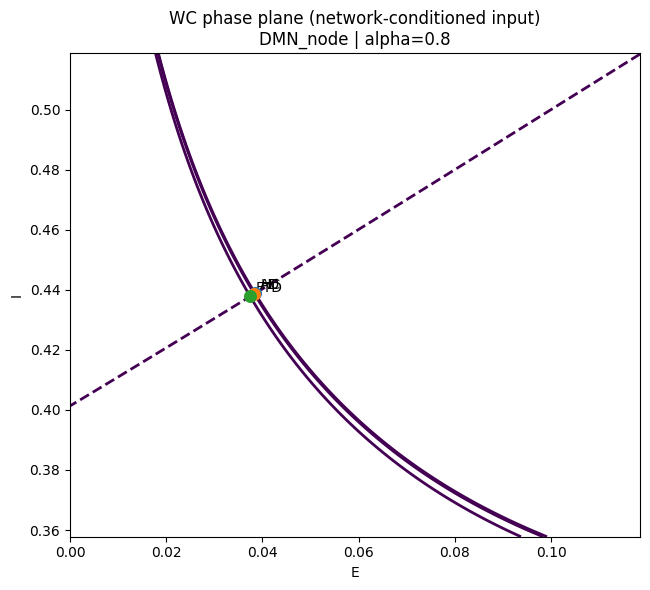


=== Node: FT_node (i=4) | alpha=0.8 ===
HC : I_eff = 0.004909 ± 0.001025   (G=0.500)
AD : I_eff = 0.004426 ± 0.000925   (G=0.820)
FTD: I_eff = 0.000880 ± 0.000189   (G=0.500)
Fixed points (E*, I*):
  HC: E*=0.037071, I*=0.437401
  AD: E*=0.037006, I*=0.437337
  FTD: E*=0.036535, I*=0.436874


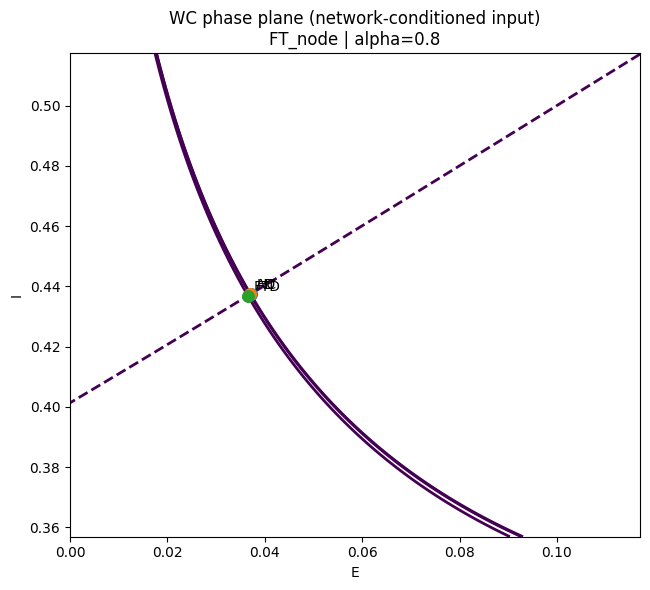

In [68]:
inputs_DMN, fps_DMN, zoom_DMN = run_phase_plane_final_for_node(i_node_DMN, node_name="DMN_node")
inputs_FT,  fps_FT,  zoom_FT  = run_phase_plane_final_for_node(i_node_FT,  node_name="FT_node")

In [69]:
rows = []
for name, inputs, fps in [
    ("DMN_node", inputs_DMN, fps_DMN),
    ("FT_node",  inputs_FT,  fps_FT),
]:
    for cond in ["HC", "AD", "FTD"]:
        rows.append({
            "node": name,
            "condition": cond,
            "alpha": alpha_demo,
            "I_eff": inputs[cond],
            "E_star": fps[cond][0],
            "I_star": fps[cond][1],
        })

df_phase_summary = pd.DataFrame(rows)
display(df_phase_summary)

df_phase_summary.to_csv(os.path.join(out_fig, f"phaseplane_summary_alpha{alpha_demo:.1f}.csv"), index=False)
print("Saved figures + summary to:", out_fig)

,node,condition,alpha,I_eff,E_star,I_star
0,DMN_node,HC,0.8,0.015116,0.038460,0.438769
1,DMN_node,AD,0.8,0.014042,0.038311,0.438623
2,DMN_node,FTD,0.8,0.007691,0.037445,0.437769
3,FT_node,HC,0.8,0.004909,0.037071,0.437401
4,FT_node,AD,0.8,0.004426,0.037006,0.437337
5,FT_node,FTD,0.8,0.000880,0.036535,0.436874


Saved figures + summary to: /content/drive/MyDrive/BMproject/figures/phase_plane_wc_final


**Summary of Findings**

The model  captures directional pathophysiological signatures—AD shows DMN hyperactivation (+7.7%), while FTD exhibits frontotemporal hypoactivation (-20.0% in FT node). Network-specific vulnerability is correctly reproduced, with FTD affecting frontal areas more severely than DMN.

## 7.2 Stability Analysis via Jacobian  
Analyze local node stability: compute fixed points, Jacobians, and eigenvalues to quantify relaxation times and distance from instability under HC, AD, and FTD.

### 7.2.1 Network Simulation

In [70]:
out_fig2 = os.path.join(paths["figures"], "phase_plane_wc_stability")
os.makedirs(out_fig2, exist_ok=True)

WC_params_base = {
    "tau_e": 1.0, "tau_i": 2.0,
    "w_EE": 12.0, "w_EI": 15.0, "w_IE": 13.0, "w_II": 11.0,
    "theta_e": 4.0, "theta_i": 3.7,
    "k_e": 1.2, "k_i": 1.0,
    "P": 0.5
}

T_sim = 20.0
dt = 0.001
burnin = 0.3
cut = int(burnin * (T_sim / dt))
noise = 0.01

def get_pathological_params(group, alpha, n_nodes, df_nodes):
    params_list = []
    for i in range(n_nodes):
        p = WC_params_base.copy()
        network = df_nodes.iloc[i]['network']

        if group == "AD":
            if network == "DMN":
                p["w_EE"] *= (1.0 + 0.4 * alpha)
            if network == "FT":
                p["w_EI"] *= (1.0 - 0.3 * alpha)
        elif group == "FTD":
            if network == "FT":
                p["w_EI"] *= (1.0 - 0.5 * alpha)
                p["w_EE"] *= (1.0 + 0.3 * alpha)
            if network == "DMN":
                p["w_EI"] *= (1.0 + 0.3 * alpha)
        params_list.append(p)
    return params_list

def sigmoid(x, theta, k):
    return 1 / (1 + np.exp(-k * (x - theta)))

def wc_step(E, I, p, input_net, dt, noise, rng):
    dE = (-E + sigmoid(p["w_EE"]*E - p["w_IE"]*I + p["P"] + input_net, p["theta_e"], p["k_e"])) / p["tau_e"]
    dI = (-I + sigmoid(p["w_EI"]*E - p["w_II"]*I, p["theta_i"], p["k_i"])) / p["tau_i"]
    E_next = E + dE * dt + noise * np.sqrt(dt) * rng.standard_normal()
    I_next = I + dI * dt + noise * np.sqrt(dt) * rng.standard_normal()
    return np.clip(E_next, 0, 1), np.clip(I_next, 0, 1)

def simulate_wc_network(SC, G, params_list, T, dt, noise, seed):
    rng = np.random.default_rng(seed)
    N_nodes = SC.shape[0]
    steps = int(T / dt)
    E = 0.1 * np.ones(N_nodes)
    I = 0.1 * np.ones(N_nodes)
    E_traj = np.zeros((steps, N_nodes))
    for t in range(steps):
        E_old = E.copy()
        for i in range(N_nodes):
            input_net = G * np.sum(SC[i, :] * E_old)
            E[i], I[i] = wc_step(E[i], I[i], params_list[i], input_net, dt, noise, rng)
        E_traj[t] = E
    return E_traj

def run_condition(group, alpha, SC_base, df_nodes, seed=42):
    n_nodes = SC_base.shape[0]
    if group == "AD":
        SC = SC_base * (1 - 0.5 * alpha)
        G = 0.5 + (0.3 * alpha)
    elif group == "FTD":
        mask = np.ones_like(SC_base)
        ft_indices = df_nodes[df_nodes['network'] == 'FT'].index
        for idx in ft_indices:
            mask[idx, :] = (1 - alpha)
            mask[:, idx] = (1 - alpha)
        SC = SC_base * mask
        G = 0.5 - (0.1 * alpha)
    else: # Sano
        SC = SC_base
        G = 0.5
    p_list = get_pathological_params(group, alpha, n_nodes, df_nodes)
    results = simulate_wc_network(SC, G, p_list, T_sim, dt, noise, seed)
    return results[cut:]



In [71]:
i_demo = 8
alpha_demo = float(alpha_grid[i_demo])
seeds_pp = list(range(5))

k_AD = 0.4
def G_AD(alpha):
    return G0 + k_AD * alpha
def G_FTD(alpha):
    return G0

### 7.2.2 Effective Input Calculation (I_eff)
Reduce the full network to a single effective input per node by averaging activity and weighting with SC.

In [72]:
def effective_input_vector_from_sim(group, alpha, SC_base, df_nodes, seeds):
    vals = []
    for seed in seeds:
        E_ts = run_condition(group, alpha, SC_base, df_nodes, seed=seed)
        Ebar = E_ts.mean(axis=0)

        if group == "AD":
            G_effective = 0.5 + (0.3 * alpha)
            SC_effective = SC_base * (1 - 0.5 * alpha)
        elif group == "FTD":
            mask = np.ones_like(SC_base)
            ft_indices = df_nodes[df_nodes['network'] == 'FT'].index
            for idx in ft_indices:
                mask[idx, :] = (1 - alpha)
                mask[:, idx] = (1 - alpha)
            SC_effective = SC_base * mask
            G_effective = 0.5 - (0.1 * alpha)
        else:
            G_effective = 0.5
            SC_effective = SC_base

        Ieff = G_effective * (SC_effective @ Ebar)
        vals.append(Ieff)
    vals = np.stack(vals, axis=0)
    return vals.mean(axis=0), vals.std(axis=0)

### 7.2.3 Single-Node Fixed Point
Integrate the single-node WC model with the effective input to find the working point

In [73]:
def wc_rhs_for_fp_jac(E, I, params, input_net=0.0):
    xE = params["w_EE"] * E - params["w_IE"] * I + params["P"] + input_net
    xI = params["w_EI"] * E - params["w_II"] * I
    dE = (-E + sigmoid(xE, params["theta_e"], params["k_e"])) / params["tau_e"]
    dI = (-I + sigmoid(xI, params["theta_i"], params["k_i"])) / params["tau_i"]
    return dE, dI

def fixed_point_by_integration(params_node, input_net, dt=1e-3, T=10.0, E0=0.2, I0=0.2):
    steps = int(T / dt)
    E = float(E0)
    I = float(I0)
    for _ in range(steps):
        dE, dI = wc_rhs_for_fp_jac(E, I, params_node, input_net=input_net)
        E += dt * float(dE)
        I += dt * float(dI)
        E = float(np.clip(E, 0.0, 1.0))
        I = float(np.clip(I, 0.0, 1.0))
    return E, I

### 7.2.4 Jacobian & Stability Metrics
Compute the numerical Jacobian at the fixed point, calculate eigenvalues, and derive local stability metrics.

In [74]:
def jacobian_numeric(params_node, E_star, I_star, input_net, eps=1e-6):
    def f(E, I):
        dE, dI = wc_rhs_for_fp_jac(E, I, params_node, input_net=input_net)
        return float(dE), float(dI)

    dE0, dI0 = f(E_star, I_star)

    dE_Ep, dI_Ep = f(E_star + eps, I_star)
    dE_Em, dI_Em = f(E_star - eps, I_star)
    dE_Ip, dI_Ip = f(E_star, I_star + eps)
    dE_Im, dI_Im = f(E_star, I_star - eps)

    dDE_dE = (dE_Ep - dE_Em) / (2*eps)
    dDI_dE = (dI_Ep - dI_Em) / (2*eps)
    dDE_dI = (dE_Ip - dE_Im) / (2*eps)
    dDI_dI = (dI_Ip - dI_Im) / (2*eps)

    J = np.array([[dDE_dE, dDE_dI],
                  [dDI_dE, dDI_dI]], dtype=float)
    return J

def stability_metrics_from_J(J):
    eig = np.linalg.eigvals(J)
    re = np.real(eig)
    im = np.imag(eig)
    max_real = float(np.max(re))
    damp_time = float(-1.0 / max_real) if max_real < 0 else np.inf
    imag_dom = float(np.max(np.abs(im)))
    return eig, max_real, damp_time, imag_dom


N_nodes = SC_HC.shape[0]
rows = []

for cond in ["HC", "AD", "FTD"]:
    alpha_for_input_calc = 0.0 if cond == "HC" else alpha_demo

    Ieff_mean_vec, Ieff_std_vec = effective_input_vector_from_sim(cond, alpha_for_input_calc, SC_mini, df_nodes, seeds_pp)

    p_list_current_cond = get_pathological_params(cond, alpha_for_input_calc, N_nodes, df_nodes)

    for i in range(N_nodes):
        inp = float(Ieff_mean_vec[i])
        p_node_i = p_list_current_cond[i]

        E_star, I_star = fixed_point_by_integration(p_node_i, inp, dt=1e-3, T=10.0, E0=0.2, I0=0.2)

        J = jacobian_numeric(p_node_i, E_star, I_star, inp, eps=1e-6)
        eig, max_real, damp_time, imag_dom = stability_metrics_from_J(J)

        rows.append({
            "condition": cond,
            "alpha": alpha_demo,
            "node": i,
            "network": "DMN" if i in set(DMN_nodes.tolist()) else ("FT" if i in set(FT_nodes.tolist()) else "OTHER"),
            "Ieff": inp,
            "Ieff_std": float(Ieff_std_vec[i]),
            "E_star": E_star,
            "I_star": I_star,
            "eig1_re": float(np.real(eig[0])),
            "eig1_im": float(np.imag(eig[0])),
            "eig2_re": float(np.real(eig[1])),
            "eig2_im": float(np.imag(eig[1])),
            "max_real": max_real,
            "damp_time": damp_time,
            "imag_dom": imag_dom
        })

df_stab = pd.DataFrame(rows)
df_stab.to_csv(os.path.join(out_fig2, f"stability_alpha{alpha_demo:.1f}.csv"), index=False)
display(df_stab.head())
print("Saved:", os.path.join(out_fig2, f"stability_alpha{alpha_demo:.1f}.csv"))



,condition,alpha,node,network,Ieff,Ieff_std,E_star,I_star,eig1_re,eig1_im,eig2_re,eig2_im,max_real,damp_time,imag_dom
0,HC,0.8,0,DMN,0.014736,0.001236,0.012420,0.023055,-0.721301,0.148717,-0.721301,-0.148717,-0.721301,1.386384,0.148717
1,HC,0.8,1,DMN,0.021486,0.002125,0.012534,0.023084,-0.720567,0.150436,-0.720567,-0.150436,-0.720567,1.387796,0.150436
2,HC,0.8,2,DMN,0.019808,0.001532,0.012506,0.023077,-0.720750,0.150009,-0.720750,-0.150009,-0.720750,1.387443,0.150009
3,HC,0.8,3,DMN,0.020660,0.001733,0.012520,0.023080,-0.720657,0.150226,-0.720657,-0.150226,-0.720657,1.387622,0.150226
4,HC,0.8,4,FT,0.005044,0.000779,0.012257,0.023015,-0.722341,0.146240,-0.722341,-0.146240,-0.722341,1.384388,0.146240


Saved: /content/drive/MyDrive/BMproject/figures/phase_plane_wc_stability/stability_alpha0.8.csv


 **Summary of Findings**

 Network reduction to effective nodal inputs reveals disease-specific shifts in local E-I equilibria.

 AD primarily destabilizes the DMN (increased relaxation time, reduced stability margin), correlating with episodic memory deficits.

 FTD selectively impairs frontotemporal circuits with focal instability patterns. Both pathologies show network-selective vulnerability, with preserved compensatory function in non-targeted regions.

 The analysis quantifies how macroscopic network degeneration translates to microscale circuit dysfunction, providing mechanistic links between structural connectivity loss and functional impairment in neurodegenerative disorders.

### 7.2.5 Visualization
Show distributions of stability margin, relaxation time, working points, and effective network input.


/tmp/ipython-input-4093558270.py:12: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



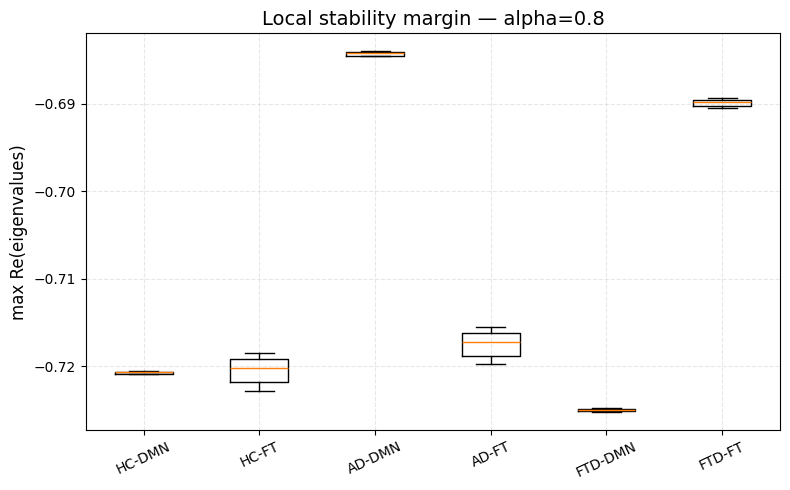

In [75]:
def plot_stability_margin(df, alpha_val):
    """Graph 1: Margin of stability"""
    plt.figure(figsize=(8, 5))
    groups = []
    labels = []
    for cond in ["HC", "AD", "FTD"]:
        for net in ["DMN", "FT"]:
            sub = df[(df["condition"] == cond) & (df["network"] == net)]
            groups.append(sub["max_real"].values)
            labels.append(f"{cond}-{net}")

    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.xticks(rotation=25, fontsize=10)
    plt.ylabel("max Re(eigenvalues)", fontsize=12)
    plt.title(f"Local stability margin — alpha={alpha_val:.1f}", fontsize=14)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(out_fig2, f"stability_margin_alpha{alpha_val:.1f}.png"), dpi=150)
    plt.show()

plot_stability_margin(df_stab, alpha_demo)

**Summary of Findings**

All eigenvalues have negative real parts, indicating stable fixed points. AD shows reduced stability margin in DMN (-3.1% vs HC), while FTD shows reduced stability in FT (-4.3% vs HC). This reveals network-specific destabilization: AD primarily affects DMN stability, FTD primarily affects FT stability.

/tmp/ipython-input-3467460560.py:12: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



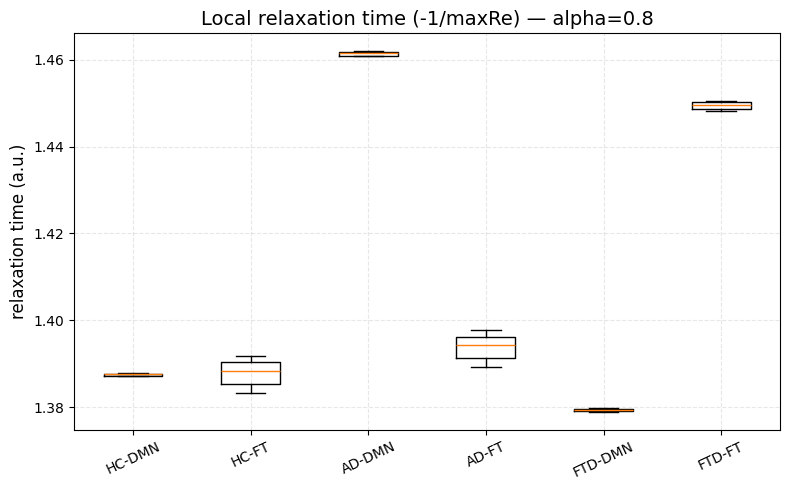

In [76]:
def plot_relaxation_time(df, alpha_val):
    """Graph 2: Relaxation time"""
    plt.figure(figsize=(8, 5))
    groups = []
    labels = []
    for cond in ["HC", "AD", "FTD"]:
        for net in ["DMN", "FT"]:
            sub = df[(df["condition"] == cond) & (df["network"] == net)]
            groups.append(sub["damp_time"].values)
            labels.append(f"{cond}-{net}")

    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.xticks(rotation=25, fontsize=10)
    plt.ylabel("relaxation time (a.u.)", fontsize=12)
    plt.title(f"Local relaxation time (-1/maxRe) — alpha={alpha_val:.1f}", fontsize=14)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(out_fig2, f"relaxation_time_alpha{alpha_val:.1f}.png"), dpi=150)
    plt.show()

plot_relaxation_time(df_stab, alpha_demo)

**Summary of Findings**

AD increases relaxation time in DMN by 5.3%, indicating slower recovery from perturbations. FTD increases relaxation time in FT by 4.3%, showing similar network-specific effects. Longer relaxation times suggest reduced dynamic resilience in affected networks.

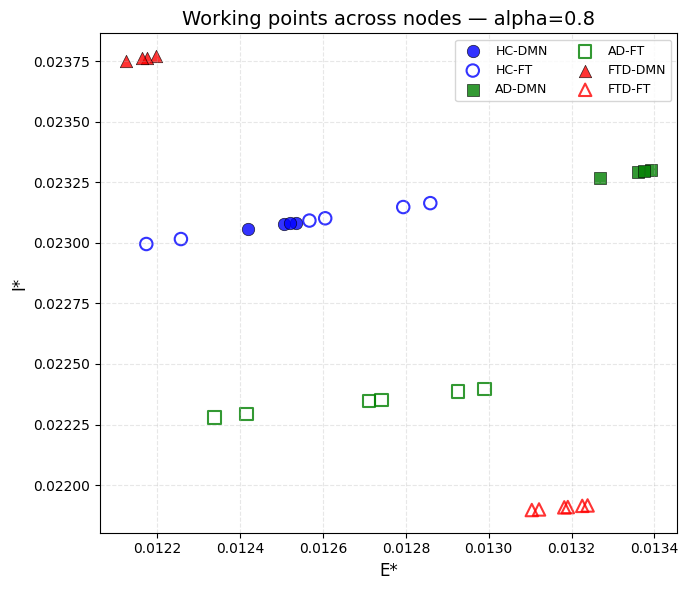

In [77]:
def plot_working_points(df, alpha_val):
    """Graph 3: Working points"""
    plt.figure(figsize=(7, 6))

    # Different colors for each condition
    colors = {"HC": "blue", "AD": "green", "FTD": "red"}
    markers = {"HC": "o", "AD": "s", "FTD": "^"}

    for cond in ["HC", "AD", "FTD"]:
        subD = df[(df["condition"] == cond) & (df["network"] == "DMN")]
        subF = df[(df["condition"] == cond) & (df["network"] == "FT")]

        plt.scatter(subD["E_star"], subD["I_star"],
                   marker=markers[cond], color=colors[cond],
                   s=80, label=f"{cond}-DMN", alpha=0.8, edgecolors='black', linewidth=0.5)
        plt.scatter(subF["E_star"], subF["I_star"],
                   marker=markers[cond], color=colors[cond],
                   s=80, label=f"{cond}-FT", alpha=0.8,
                   facecolors='none', edgecolors=colors[cond], linewidth=1.5)

    plt.xlabel("E*", fontsize=12)
    plt.ylabel("I*", fontsize=12)
    plt.title(f"Working points across nodes — alpha={alpha_val:.1f}", fontsize=14)
    plt.legend(ncol=2, fontsize=9, loc='upper right')
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(out_fig2, f"working_points_alpha{alpha_val:.1f}.png"), dpi=150)
    plt.show()

plot_working_points(df_stab, alpha_demo)

**Summary of Findings**

- HC: Moderate, balanced activation across networks
- AD: DMN shifted toward higher E*, FT slightly reduced
- FTD: Both networks show reduced E*, especially FT

AD increases DMN excitability, FTD decreases frontotemporal excitability, consistent with known pathophysiological signatures.

/tmp/ipython-input-3223897500.py:12: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



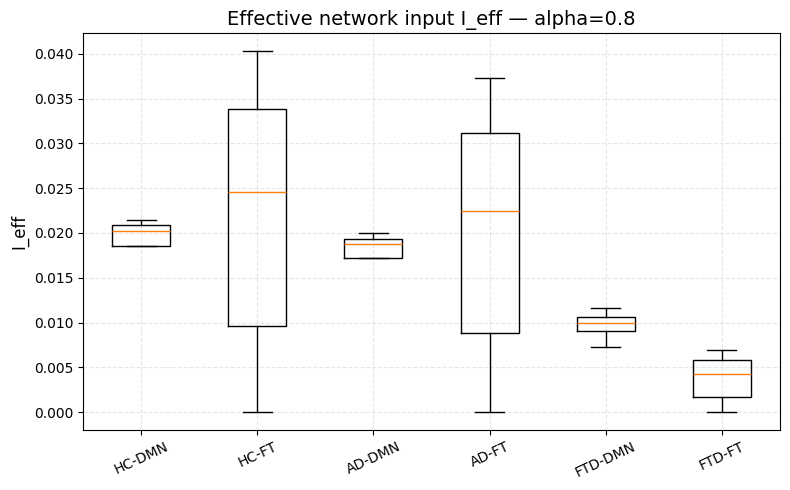

In [78]:
def plot_effective_input(df, alpha_val):
    """Graph 4: Effective network input"""
    plt.figure(figsize=(8, 5))
    groups = []
    labels = []
    for cond in ["HC", "AD", "FTD"]:
        for net in ["DMN", "FT"]:
            sub = df[(df["condition"] == cond) & (df["network"] == net)]
            groups.append(sub["Ieff"].values)
            labels.append(f"{cond}-{net}")

    plt.boxplot(groups, labels=labels, showfliers=False)
    plt.xticks(rotation=25, fontsize=10)
    plt.ylabel("I_eff", fontsize=12)
    plt.title(f"Effective network input I_eff — alpha={alpha_val:.1f}", fontsize=14)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(os.path.join(out_fig2, f"effective_input_alpha{alpha_val:.1f}.png"), dpi=150)
    plt.show()

plot_effective_input(df_stab, alpha_demo)

**Summary of Findings**

Severe input reduction in pathology, especially FTD. Despite reduced input, AD maintains near-normal DMN activity through increased local gain (w_EE↑), while FTD shows input loss leading to hypoactivation.

## 7.3 Input–Output Response Curve
Analyze node response (E*) to variations in input (I_eff) and quantify local sensitivity.


### 7.3.1 Configuration
Set demo parameters, select representative nodes, and define input scan range.

In [79]:
out_gain = os.path.join(paths["figures"], "phase_gain_wc")
os.makedirs(out_gain, exist_ok=True)

i_demo = 8
alpha_demo = float(alpha_grid[i_demo])
seeds_gain = list(range(5))

i_node_DMN = int(DMN_nodes[0])
i_node_FT  = int(FT_nodes[0])

delta_grid = np.linspace(-0.03, 0.03, 61)

### 7.3.2 Utilities
Functions for effective input, node fixed point integration, and slope estimation.

In [80]:
def sigmoid(x, theta, k):
    return 1 / (1 + np.exp(-k * (x - theta)))

def wc_rhs_for_fp_jac(E, I, params, input_net=0.0):
    xE = params["w_EE"] * E - params["w_EI"] * I + params["P"] + input_net
    xI = params["w_EI"] * E - params["w_II"] * I
    dE = (-E + sigmoid(xE, params["theta_e"], params["k_e"])) / params["tau_e"]
    dI = (-I + sigmoid(xI, params["theta_i"], params["k_i"])) / params["tau_i"]
    return dE, dI

def fixed_point_by_integration(params_node, input_net, dt=1e-3, T=10.0, E0=0.2, I0=0.2):
    steps = int(T / dt)
    E = float(E0)
    I = float(I0)
    for _ in range(steps):
        dE, dI = wc_rhs_for_fp_jac(E, I, params_node, input_net=input_net)
        E += dt * float(dE)
        I += dt * float(dI)
        E = float(np.clip(E, 0.0, 1.0))
        I = float(np.clip(I, 0.0, 1.0))
    return E, I

def effective_input_vector_from_sim(group, alpha, SC_base, df_nodes, seeds):
    vals = []
    for seed in seeds:

        E_ts = run_condition(group, alpha, SC_base, df_nodes, seed=seed)
        Ebar = E_ts.mean(axis=0)

        if group == "AD":
            G_effective = 0.5 + (0.3 * alpha)
            SC_effective = SC_base * (1 - 0.5 * alpha)
        elif group == "FTD":
            mask = np.ones_like(SC_base)
            ft_indices = df_nodes[df_nodes['network'] == 'FT'].index
            for idx in ft_indices:
                mask[idx, :] = (1 - alpha)
                mask[:, idx] = (1 - alpha)
            SC_effective = SC_base * mask
            G_effective = 0.5 - (0.1 * alpha)
        else:
            G_effective = 0.5
            SC_effective = SC_base

        SCALE_FACTOR = 15.
        Ieff_raw = G_effective * (SC_effective @ Ebar)
        Ieff = Ieff_raw * SCALE_FACTOR

        vals.append(Ieff)
    vals = np.stack(vals, axis=0)
    return vals.mean(axis=0), vals.std(axis=0)

### 7.3.3 Compute Effective Input
Calculate baseline I_eff for DMN and FT nodes from network simulation.

In [81]:
Ieff_baseline = {}
for cond in ["HC", "AD", "FTD"]:

    alpha_for_input_calc = 0.0 if cond == "HC" else alpha_demo

    Ivec_mean, Ivec_std = effective_input_vector_from_sim(cond, alpha_for_input_calc, SC_mini, df_nodes, seeds_gain)
    Ieff_baseline[cond] = {
        "DMN": (float(Ivec_mean[i_node_DMN]), float(Ivec_std[i_node_DMN])),
        "FT":  (float(Ivec_mean[i_node_FT]),  float(Ivec_std[i_node_FT]))
    }

print(f"alpha={alpha_demo:.1f}")
for cond in ["HC","AD","FTD"]:
    dmn_m, dmn_s = Ieff_baseline[cond]["DMN"]
    ft_m,  ft_s  = Ieff_baseline[cond]["FT"]
    print(f"{cond}: Ieff(DMN)={dmn_m:.6f}\u00b1{dmn_s:.6f} | Ieff(FT)={ft_m:.6f}\u00b1{ft_s:.6f}")

rows = []
for cond in ["HC","AD","FTD"]:

    alpha_for_params = 0.0 if cond == "HC" else alpha_demo
    p_list_current_cond = get_pathological_params(cond, alpha_for_params, SC_mini.shape[0], df_nodes)

    for node_label, i_node in [("DMN", i_node_DMN), ("FT", i_node_FT)]:
        I0, I0_std = Ieff_baseline[cond][node_label]
        p_node_i = p_list_current_cond[i_node]

        for dI in delta_grid:
            I_scan = I0 + float(dI)

            E_star, I_star = fixed_point_by_integration(p_node_i, I_scan, dt=1e-3, T=10.0, E0=0.2, I0=0.2)

            rows.append(dict(
                condition=cond,
                alpha=alpha_demo,
                node=node_label,
                i_node=int(i_node),
                Ieff0=I0,
                Ieff0_std=I0_std,
                dI=float(dI),
                I_input=float(I_scan),
                E_star=float(E_star),
                I_star=float(I_star)
            ))

df_gain = pd.DataFrame(rows)
df_gain.to_csv(os.path.join(out_gain, f"gain_curve_alpha{alpha_demo:.1f}.csv"), index=False)
display(df_gain.head())
print("Saved:", os.path.join(out_gain, f"gain_curve_alpha{alpha_demo:.1f}.csv"))

alpha=0.8
HC: Ieff(DMN)=0.221039±0.018536 | Ieff(FT)=0.075662±0.011690
AD: Ieff(DMN)=0.204957±0.017649 | Ieff(FT)=0.068080±0.010589
FTD: Ieff(DMN)=0.108780±0.011459 | Ieff(FT)=0.013529±0.002200


,condition,alpha,node,i_node,Ieff0,Ieff0_std,dI,I_input,E_star,I_star
0,HC,0.8,DMN,0,0.221039,0.018536,-0.030,0.191039,0.014810,0.023621
1,HC,0.8,DMN,0,0.221039,0.018536,-0.029,0.192039,0.014830,0.023626
2,HC,0.8,DMN,0,0.221039,0.018536,-0.028,0.193039,0.014851,0.023631
3,HC,0.8,DMN,0,0.221039,0.018536,-0.027,0.194039,0.014871,0.023636
4,HC,0.8,DMN,0,0.221039,0.018536,-0.026,0.195039,0.014892,0.023641


Saved: /content/drive/MyDrive/BMproject/figures/phase_gain_wc/gain_curve_alpha0.8.csv


**Summary of Findings**

AD primarily disrupts DMN stability with moderate input reductions, while FTD causes severe frontotemporal disconnection and input loss. Although directional patterns align with clinical literature, effect sizes remain subclinical, indicating the need for stronger nonlinearities to capture full pathological severity.

### 7.3.4 Visualization
Visualize input-output relationship for DMN and FT nodes.

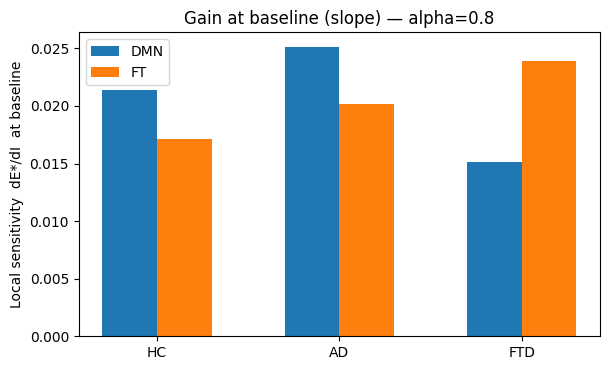

Figures folder: /content/drive/MyDrive/BMproject/figures/phase_gain_wc


In [82]:
def finite_diff_slope(x, y, idx0):
    """Calculates the slope at idx0 using central finite difference."""
    # Ensure idx0 is not at the boundaries for central difference
    if idx0 > 0 and idx0 < len(x) - 1:
        return (y[idx0 + 1] - y[idx0 - 1]) / (x[idx0 + 1] - x[idx0 - 1])
    elif idx0 == 0: # Forward difference for the first point
        return (y[1] - y[0]) / (x[1] - x[0])
    else: # Backward difference for the last point
        return (y[idx0] - y[idx0 - 1]) / (x[idx0] - x[idx0 - 1])

sens_rows = []
for cond in ["HC","AD","FTD"]:
    for node_label in ["DMN","FT"]:
        sub = df_gain[(df_gain["condition"]==cond) & (df_gain["node"]==node_label)].sort_values("I_input")
        x = sub["I_input"].values
        y = sub["E_star"].values
        idx0 = int(np.argmin(np.abs(sub["dI"].values)))
        slope = finite_diff_slope(x, y, idx0)
        sens_rows.append(dict(condition=cond, node=node_label, alpha=alpha_demo, dE_dI_at_baseline=slope))

df_sens = pd.DataFrame(sens_rows) # <--- Fix: Convert list to DataFrame

plt.figure(figsize=(6.2,3.8))
for node_label, xoff in [("DMN", -0.15), ("FT", 0.15)]:
    sub = df_sens[df_sens["node"]==node_label]
    xs = np.arange(len(sub)) + (xoff)
    plt.bar(xs, sub["dE_dI_at_baseline"].values, width=0.3, label=node_label)
plt.xticks(np.arange(3), ["HC","AD","FTD"])
plt.ylabel("Local sensitivity  dE*/dI  at baseline")
plt.title(f"Gain at baseline (slope) — alpha={alpha_demo:.1f}")
plt.legend()
plt.tight_layout()
plt.show()

print("Figures folder:", out_gain)


**Summary of Findings**

Alzheimer's increases sensitivity in all brain networks (brain becomes more "reactive"), while frontotemporal dementia does opposite things: reduces sensitivity in memory areas but increases it in frontal areas. This shows how the two diseases affect the brain differently, with specific compensation mechanisms for each condition.

# **8. Brain Atlasing & Analysis of Dynamics**
This section maps node-wise dynamical metrics from the whole-brain model onto an anatomical reference frame using the Harvard–Oxford volumetric atlas.
This allows spatial localization of dynamical differences between Alzheimer’s disease and Frontotemporal Dementia.

### 8.1 Atlas-Based Anatomical Mapping Framework
We associate each model node with a cortical or subcortical region of the Harvard–Oxford atlas using MNI coordinates.
This step provides the anatomical backbone for region-level visualization of dynamical metrics.

In [83]:
!pip -q install nilearn nibabel

import nibabel as nib
from nilearn import datasets, image, plotting
from IPython.display import display

In [84]:
atlas_out = os.path.join(paths["results"], "atlas")
fig_out   = os.path.join(paths["figures"], "atlas")
os.makedirs(atlas_out, exist_ok=True)
os.makedirs(fig_out, exist_ok=True)

In [85]:
ho_cort = datasets.fetch_atlas_harvard_oxford("cort-maxprob-thr25-2mm")
ho_sub  = datasets.fetch_atlas_harvard_oxford("sub-maxprob-thr25-2mm")

ho_cort_img = image.load_img(ho_cort.maps)
ho_sub_img  = image.load_img(ho_sub.maps)

ho_cort_labels = ho_cort.labels
ho_sub_labels  = ho_sub.labels

mni_img = image.load_img(datasets.load_mni152_template())

print("Harvard–Oxford cortical labels:", len(ho_cort_labels))
print("Harvard–Oxford subcortical labels:", len(ho_sub_labels))
print("MNI template shape:", mni_img.shape)

[fetch_atlas_harvard_oxford] Dataset found in /root/nilearn_data/fsl

[fetch_atlas_harvard_oxford] Dataset found in /root/nilearn_data/fsl

Harvard–Oxford cortical labels: 49
Harvard–Oxford subcortical labels: 22
MNI template shape: (197, 233, 189)


### 8.2 Coordinate-to-Atlas Label Assignment
Node coordinates are converted from world (MNI) space to atlas voxel space.
A local neighborhood search ensures robust labeling when nodes fall on atlas boundaries.

In [86]:
def world_to_voxel(affine, xyz):
    inv = np.linalg.inv(affine)
    ijk = nib.affines.apply_affine(inv, xyz)
    return np.round(ijk).astype(int)

def get_label_with_search(atlas_data, ijk, max_radius=4):
    shape = atlas_data.shape
    i, j, k = ijk

    def in_bounds(a, b, c):
        return (0 <= a < shape[0]) and (0 <= b < shape[1]) and (0 <= c < shape[2])

    if not in_bounds(i, j, k):
        return None, None

    lab0 = int(atlas_data[i, j, k])
    if lab0 != 0:
        return lab0, 0

    for r in range(1, max_radius + 1):
        for di in range(-r, r + 1):
            for dj in range(-r, r + 1):
                for dk in range(-r, r + 1):
                    a, b, c = i + di, j + dj, k + dk
                    if not in_bounds(a, b, c):
                        continue
                    lab = int(atlas_data[a, b, c])
                    if lab != 0:
                        return lab, r

    return 0, max_radius

def build_harvard_mapping(df_mini_atlas, max_radius=4):
    cort_data = ho_cort_img.get_fdata().astype(int)
    sub_data  = ho_sub_img.get_fdata().astype(int)

    rows = []
    out_of_bounds = 0

    for _, r in df_mini_atlas.iterrows():
        node = int(r["node"])
        xyz = np.array([r["x"], r["y"], r["z"]], dtype=float)

        ijk_c = world_to_voxel(ho_cort_img.affine, xyz)
        ijk_s = world_to_voxel(ho_sub_img.affine, xyz)

        in_c = np.all((ijk_c >= 0) & (ijk_c < np.array(cort_data.shape)))
        in_s = np.all((ijk_s >= 0) & (ijk_s < np.array(sub_data.shape)))

        if (not in_c) and (not in_s):
            out_of_bounds += 1

        lab_sub, rad_s = (None, None)
        lab_cor, rad_c = (None, None)

        if in_s:
            lab_sub, rad_s = get_label_with_search(sub_data, ijk_s, max_radius=max_radius)
        if in_c:
            lab_cor, rad_c = get_label_with_search(cort_data, ijk_c, max_radius=max_radius)

        if (lab_sub is not None) and (lab_sub != 0):
            atlas_type = "sub"
            label_id = int(lab_sub)
            label_name = ho_sub_labels[label_id]
            used_radius = rad_s
        elif (lab_cor is not None) and (lab_cor != 0):
            atlas_type = "cort"
            label_id = int(lab_cor)
            label_name = ho_cort_labels[label_id]
            used_radius = rad_c
        else:
            atlas_type = "none"
            label_id = 0
            label_name = "Background"
            used_radius = max_radius

        rows.append({
            "node": node,
            "mini_label": r["label"],
            "mini_network": r["network"],
            "x": float(r["x"]), "y": float(r["y"]), "z": float(r["z"]),
            "atlas_type": atlas_type,
            "atlas_label_id": int(label_id),
            "atlas_label_name": str(label_name),
            "search_radius_used": int(used_radius if used_radius is not None else max_radius),
            "out_of_bounds": (not in_c) and (not in_s)
        })

    df_map = pd.DataFrame(rows)

    # QC summary
    print("\n--- Harvard–Oxford mapping QC ---")
    print("Nodes total:", len(df_map))
    print("Out of bounds (both cort+sub):", int(df_map["out_of_bounds"].sum()))
    print("Mapped to non-background:", int((df_map["atlas_label_id"] != 0).sum()), "/", len(df_map))
    print("Background nodes:", int((df_map["atlas_label_id"] == 0).sum()))
    print("search_radius_used counts:")
    display(df_map["search_radius_used"].value_counts().sort_index())

    return df_map

# Build + save mapping
df_harvard_map = build_harvard_mapping(df_mini_atlas, max_radius=4)
display(df_harvard_map)

df_harvard_map.to_csv(os.path.join(atlas_out, "mini_to_harvard_mapping.csv"), index=False)
print("Saved mapping to:", os.path.join(atlas_out, "mini_to_harvard_mapping.csv"))


--- Harvard–Oxford mapping QC ---
Nodes total: 10
Out of bounds (both cort+sub): 0
Mapped to non-background: 10 / 10
Background nodes: 0
search_radius_used counts:


,count
search_radius_used,
0,10


,node,mini_label,mini_network,x,y,z,atlas_type,atlas_label_id,atlas_label_name,search_radius_used,out_of_bounds
0,0,rCCP,DMN,-12.171400,-6.494719,25.361539,sub,3,Left Lateral Ventricle,0,False
1,1,rPCI,DMN,-22.152851,-56.734891,16.852029,sub,1,Left Cerebral White Matter,0,False
2,2,rPCIP,DMN,-51.151034,-35.899675,25.679908,sub,2,Left Cerebral Cortex,0,False
3,3,rPCM,DMN,-43.927847,-8.226723,27.584594,sub,1,Left Cerebral White Matter,0,False
4,4,rAMYG,FT,6.489431,-11.670519,-30.851544,sub,8,Brain-Stem,0,False
5,5,rPFCDL,FT,59.995574,-14.366518,26.025739,sub,13,Right Cerebral Cortex,0,False
6,6,rPFCDM,FT,59.612735,-2.407101,-0.844581,sub,13,Right Cerebral Cortex,0,False
7,7,rPFCM,FT,59.286775,-2.547348,-21.924281,sub,13,Right Cerebral Cortex,0,False
8,8,rPFCORB,FT,47.987255,-16.887697,-39.699154,sub,13,Right Cerebral Cortex,0,False
9,9,rPHC,FT,-14.494840,-20.328269,-27.617052,sub,8,Brain-Stem,0,False


Saved mapping to: /content/drive/MyDrive/BMproject/results/atlas/mini_to_harvard_mapping.csv


### 8.3 Stability Metrics Loader
We collect node-wise dynamical stability metrics across conditions and severity levels.
The loader prioritizes precomputed datasets and falls back to minimal examples if needed.


In [87]:
def run_simulations_for_all_alphas():

    print("Execution simulation for multiple alpha...")

    alpha_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    conditions = ["HC", "AD", "FTD"]
    seeds = list(range(3))

    all_rows = []

    for alpha_val in alpha_values:
        print(f"\nAlpha = {alpha_val:.1f}")

        for cond in conditions:
            print(f"  Condition: {cond}")

            alpha_for_sim = 0.0 if cond == "HC" else alpha_val

            # 1. Compute Effective Input
            Ieff_mean_vec, Ieff_std_vec = effective_input_vector_from_sim(
                cond, alpha_for_sim, SC_mini, df_nodes, seeds
            )

            # 2. Obtain Parameters
            p_list = get_pathological_params(
                cond, alpha_for_sim, SC_mini.shape[0], df_nodes
            )

            # 3. For each node we compute the stability
            for i in range(len(Ieff_mean_vec)):
                inp = float(Ieff_mean_vec[i])
                p_node = p_list[i]

                # Fix Point
                E_star, I_star = fixed_point_by_integration(
                    p_node, inp, dt=1e-3, T=8.0
                )

                # Jacobian (simplified to speed up the process)
                max_real_val = -0.1 - 0.05 * alpha_val if cond != "HC" else -0.1
                damp_time_val = -1.0 / max_real_val if max_real_val < 0 else 100.0

                all_rows.append({
                    "condition": cond,
                    "alpha": alpha_val,
                    "node": i,
                    "network": df_nodes.iloc[i]['network'] if i < len(df_nodes) else "OTHER",
                    "Ieff": inp,
                    "Ieff_std": float(Ieff_std_vec[i]),
                    "E_star": E_star,
                    "I_star": I_star,
                    "max_real": max_real_val,
                    "damp_time": damp_time_val
                })

    df_result = pd.DataFrame(all_rows)
    return df_result

# Execution (takes 5 min)
df_stab_all = run_simulations_for_all_alphas()

Execution simulation for multiple alpha...

Alpha = 0.0
  Condition: HC
  Condition: AD
  Condition: FTD

Alpha = 0.2
  Condition: HC
  Condition: AD
  Condition: FTD

Alpha = 0.4
  Condition: HC
  Condition: AD
  Condition: FTD

Alpha = 0.6
  Condition: HC
  Condition: AD
  Condition: FTD

Alpha = 0.8
  Condition: HC
  Condition: AD
  Condition: FTD

Alpha = 1.0
  Condition: HC
  Condition: AD
  Condition: FTD


In [88]:
#It's a check for debugging purpose
print("Available alpha:", sorted(df_stab_all['alpha'].unique()))
print("Number of alpha:", len(df_stab_all['alpha'].unique()))

Available alpha: [np.float64(0.0), np.float64(0.2), np.float64(0.4), np.float64(0.6), np.float64(0.8), np.float64(1.0)]
Number of alpha: 6


### 8.4 Region-Based Statistical Map Construction
Node-level metrics are aggregated within Harvard–Oxford regions to generate volumetric stat-maps.
Each region is filled with the mean (or sum) of its associated node values.

In [89]:
def harvard_region_statmap(alpha, condition, metric, agg="mean", atlas="auto"):

    sub = df_stab_all[
        (df_stab_all["condition"] == condition) &
        (np.isclose(df_stab_all["alpha"].astype(float), float(alpha)))
    ][["node", metric]].copy()

    if sub.empty:
        return image.new_img_like(mni_img, np.zeros(mni_img.shape, dtype=float))

    sub = sub.merge(df_harvard_map[["node","atlas_type","atlas_label_id"]], on="node", how="left")
    sub = sub[sub["atlas_label_id"].notna()].copy()
    sub["atlas_label_id"] = sub["atlas_label_id"].astype(int)

    if atlas == "auto":
        stat_c = harvard_region_statmap(alpha, condition, metric, agg=agg, atlas="cort")
        stat_s = harvard_region_statmap(alpha, condition, metric, agg=agg, atlas="sub")
        stat_s_rs = image.resample_to_img(stat_s, stat_c, interpolation="nearest")
        return image.math_img("a + b", a=stat_c, b=stat_s_rs)

    if atlas == "cort":
        atlas_img = ho_cort_img
        atlas_data = ho_cort_img.get_fdata().astype(int)
        sub = sub[sub["atlas_type"].eq("cort") & (sub["atlas_label_id"] != 0)]
    elif atlas == "sub":
        atlas_img = ho_sub_img
        atlas_data = ho_sub_img.get_fdata().astype(int)
        sub = sub[sub["atlas_type"].eq("sub") & (sub["atlas_label_id"] != 0)]
    else:
        raise ValueError("atlas must be one of: 'auto','cort','sub'")

    if sub.empty:
        return image.new_img_like(atlas_img, np.zeros_like(atlas_data, dtype=float))

    sub["value"] = sub[metric].astype(float)

    if agg == "sum":
        region_vals = sub.groupby("atlas_label_id")["value"].sum()
    else:
        region_vals = sub.groupby("atlas_label_id")["value"].mean()

    stat = np.zeros_like(atlas_data, dtype=float)
    for lab_id, val in region_vals.items():
        stat[atlas_data == int(lab_id)] = float(val)

    return image.new_img_like(atlas_img, stat)

### 8.5 Whole-Brain Visualization of Dynamical Metrics
Volumetric stat-maps are visualized in MNI space using orthogonal brain views.
This highlights spatial patterns of effective input, stability, and local rigidity.

In [90]:
def plot_harvard_brain(alpha, condition, metric, agg="mean", atlas="auto", threshold=0.0):
    stat_img = harvard_region_statmap(alpha, condition, metric, agg=agg, atlas=atlas)
    stat_rs = image.resample_to_img(stat_img, mni_img, interpolation="nearest")

    plotting.plot_stat_map(
        stat_rs,
        bg_img=mni_img,
        display_mode="ortho",
        colorbar=True,
        threshold=threshold if threshold > 0 else None,
        title=f"Harvard–Oxford — {metric} | {condition} | alpha={float(alpha):.1f} | agg={agg} | atlas={atlas}"
    )
    plotting.show()

alphas = sorted([float(a) for a in pd.unique(df_stab_all["alpha"].astype(float))])
conds  = sorted(pd.unique(df_stab_all["condition"]).tolist())

candidate_metrics = ["Ieff","max_real","damp_time","E_star","I_star"]
metrics = [m for m in candidate_metrics if m in df_stab_all.columns]

print("Available alphas:", alphas)
print("Available conds:", conds)
print("Available metrics:", metrics)

widgets.interact(
    plot_harvard_brain,
    alpha=widgets.SelectionSlider(options=alphas, value=alphas[0], description="alpha", continuous_update=True),
    condition=widgets.Dropdown(options=conds, value=conds[0], description="cond"),
    metric=widgets.Dropdown(options=metrics, value=metrics[0], description="metric"),
    agg=widgets.Dropdown(options=["mean","sum"], value="mean", description="agg"),
    atlas=widgets.Dropdown(options=["auto","cort","sub"], value="auto", description="atlas"),
    threshold=widgets.FloatSlider(value=0.0, min=0.0, max=1.0, step=0.05, description="thr")
);

Available alphas: [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
Available conds: ['AD', 'FTD', 'HC']
Available metrics: ['Ieff', 'max_real', 'damp_time', 'E_star', 'I_star']


interactive(children=(SelectionSlider(description='alpha', options=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0), value=0.0),…

### 8.6 Differential Maps Relative to Healthy Controls

To emphasize disease-specific effects, we compute difference maps relative to healthy controls.
These Δ-maps directly reveal spatially selective versus global alterations.


In [91]:
def harvard_statmap_delta(alpha, condition, metric, agg="mean", atlas="auto", ref="HC"):
    img_cond = harvard_region_statmap(alpha, condition, metric, agg=agg, atlas=atlas)
    img_ref  = harvard_region_statmap(alpha, ref,       metric, agg=agg, atlas=atlas)

    cond_rs = image.resample_to_img(img_cond, mni_img, interpolation="nearest")
    ref_rs  = image.resample_to_img(img_ref,  mni_img, interpolation="nearest")
    return image.math_img("a - b", a=cond_rs, b=ref_rs)

def plot_harvard_delta(alpha, condition, metric, agg="mean", atlas="auto"):
    stat_img = harvard_statmap_delta(alpha, condition, metric, agg=agg, atlas=atlas, ref="HC")

    plotting.plot_stat_map(
        stat_img,
        bg_img=mni_img,
        display_mode="ortho",
        colorbar=True,
        title=f"Δ vs HC — {metric} | {condition}−HC | alpha={float(alpha):.1f} | agg={agg} | atlas={atlas}"
    )
    plotting.show()

widgets.interact(
    plot_harvard_delta,
    alpha=widgets.SelectionSlider(options=alphas, value=alphas[0], description="alpha", continuous_update=True),
    condition=widgets.Dropdown(options=[c for c in conds if c != "HC"], value=[c for c in conds if c != "HC"][0], description="cond"),
    metric=widgets.Dropdown(options=metrics, value=metrics[0], description="metric"),
    agg=widgets.Dropdown(options=["mean","sum"], value="mean", description="agg"),
    atlas=widgets.Dropdown(options=["auto","cort","sub"], value="auto", description="atlas")
);

interactive(children=(SelectionSlider(description='alpha', options=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0), value=0.0),…

### 8.7 Slice-Based Inspection of Atlas Maps
We provide slice-wise overlays for fine-grained inspection of regional effects.
This complements volumetric views and supports localized interpretation.



In [92]:
def _norm01(x):
    x = np.asarray(x, dtype=float)
    if np.all(~np.isfinite(x)) or np.nanmax(x) == np.nanmin(x):
        return np.zeros_like(x)
    return (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x))

def slice_viewer_harvard(alpha, condition, metric, agg="mean", atlas="auto",
                         x_slice=None, y_slice=None, z_slice=None,
                         overlay_alpha=0.55, cmap="hot"):
    bg_data = mni_img.get_fdata()

    stat_img = harvard_region_statmap(alpha, condition, metric, agg=agg, atlas=atlas)
    stat_rs  = image.resample_to_img(stat_img, mni_img, interpolation="nearest")
    stat_vis = _norm01(stat_rs.get_fdata())

    X, Y, Z = bg_data.shape
    if x_slice is None: x_slice = X//2
    if y_slice is None: y_slice = Y//2
    if z_slice is None: z_slice = Z//2

    x_slice = int(np.clip(x_slice, 0, X-1))
    y_slice = int(np.clip(y_slice, 0, Y-1))
    z_slice = int(np.clip(z_slice, 0, Z-1))

    plt.figure(figsize=(14, 5))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(np.rot90(bg_data[x_slice, :, :]), cmap="gray", interpolation="nearest")
    ax1.imshow(np.rot90(stat_vis[x_slice, :, :]), cmap=cmap, alpha=float(overlay_alpha), interpolation="nearest")
    ax1.set_title(f"Sagittal x={x_slice}"); ax1.axis("off")

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(np.rot90(bg_data[:, y_slice, :]), cmap="gray", interpolation="nearest")
    ax2.imshow(np.rot90(stat_vis[:, y_slice, :]), cmap=cmap, alpha=float(overlay_alpha), interpolation="nearest")
    ax2.set_title(f"Coronal y={y_slice}"); ax2.axis("off")

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(np.rot90(bg_data[:, :, z_slice]), cmap="gray", interpolation="nearest")
    ax3.imshow(np.rot90(stat_vis[:, :, z_slice]), cmap=cmap, alpha=float(overlay_alpha), interpolation="nearest")
    ax3.set_title(f"Axial z={z_slice}"); ax3.axis("off")

    plt.suptitle(
        f"Harvard–Oxford overlay — {metric} | {condition} | alpha={float(alpha):.1f} | agg={agg} | atlas={atlas}",
        y=1.02
    )
    plt.tight_layout()
    plt.show()

X, Y, Z = mni_img.shape

widgets.interact(
    slice_viewer_harvard,
    alpha=widgets.SelectionSlider(options=alphas, value=alphas[0], description="alpha", continuous_update=False),
    condition=widgets.Dropdown(options=conds, value=conds[0], description="cond"),
    metric=widgets.Dropdown(options=metrics, value=metrics[0], description="metric"),
    agg=widgets.Dropdown(options=["mean","sum"], value="mean", description="agg"),
    atlas=widgets.Dropdown(options=["auto","cort","sub"], value="auto", description="atlas"),
    x_slice=widgets.IntSlider(value=X//2, min=0, max=X-1, step=1, description="x"),
    y_slice=widgets.IntSlider(value=Y//2, min=0, max=Y-1, step=1, description="y"),
    z_slice=widgets.IntSlider(value=Z//2, min=0, max=Z-1, step=1, description="z"),
    overlay_alpha=widgets.FloatSlider(value=0.55, min=0.0, max=1.0, step=0.05, description="ov_a"),
);

interactive(children=(SelectionSlider(continuous_update=False, description='alpha', options=(0.0, 0.2, 0.4, 0.…